# Laboratorium 1

Przygotuj następujące zbiory punktów (2D, współrzędne rzeczywiste typu double):

    a) 10^5 losowych punktów o współrzędnych z przedziału [-1000, 1000],

    b) 10^5 losowych punktów o współrzędnych z przedziału [-10^14 , 10^14],

    c) 1000 losowych punktów leżących na okręgu o środku (0,0) i promieniu R=100,

    d) 1000 losowych punktów o współrzędnych z przedziału [-1000, 1000] leżących na prostej wyznaczonej przez 
    wektor (a, b), przyjmij a = [-1.0, 0.0], b = [1.0, 0.1].

In [424]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import timeit
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js
import random
# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes,rect):
        self.i = 0
        self.rect = rect
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                if(self.rect == "scatter"):
                    self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
                elif(self.rect == "hexbin"):
                    self.ax.hexbin(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


In [2]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None,rect = "scatter"):
        if json is None:
            self.scenes = scenes
            self.rect = rect
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.rect = rect
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes,self.rect)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

# Rozwiązanie

#### a) 10^5 losowych punktów o współrzędnych z przedziału [-1000, 1000]

<IPython.core.display.Javascript object>


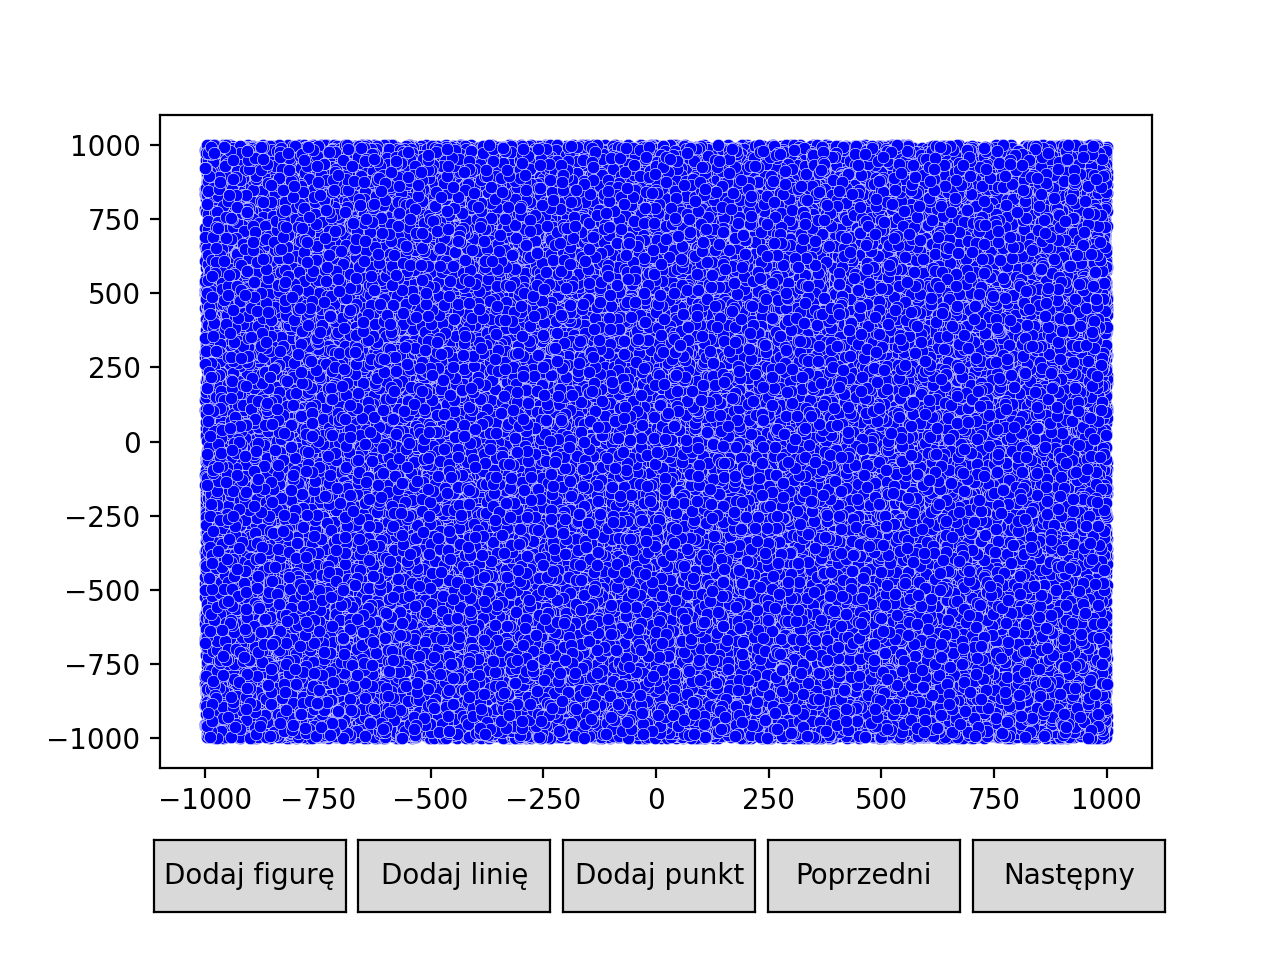

In [3]:
%matplotlib notebook
z = 10**5
x = np.random.uniform(-1000,1000,z)
y = np.random.uniform(-1000,1000,z)
tab1 = []
# points = PointsCollection(tab1,gridsize=50,bins="log",cmap=plt.colormaps["Reds"],linewidths=0.05,edgecolors="black")
points = PointsCollection(tab1,c="blue",s=20,edgecolors="white",linewidths=0.2)
for i in range(len(x)):
    tab1.append((x[i],y[i]))
scenes=[Scene([points])]
plot3 = Plot(scenes = scenes,rect = "scatter")
plot3.draw()

#### b) 10^5 losowych punktów o współrzędnych z przedziału [-10^14 , 10^14]

/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_4750/3508443624.py:123: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


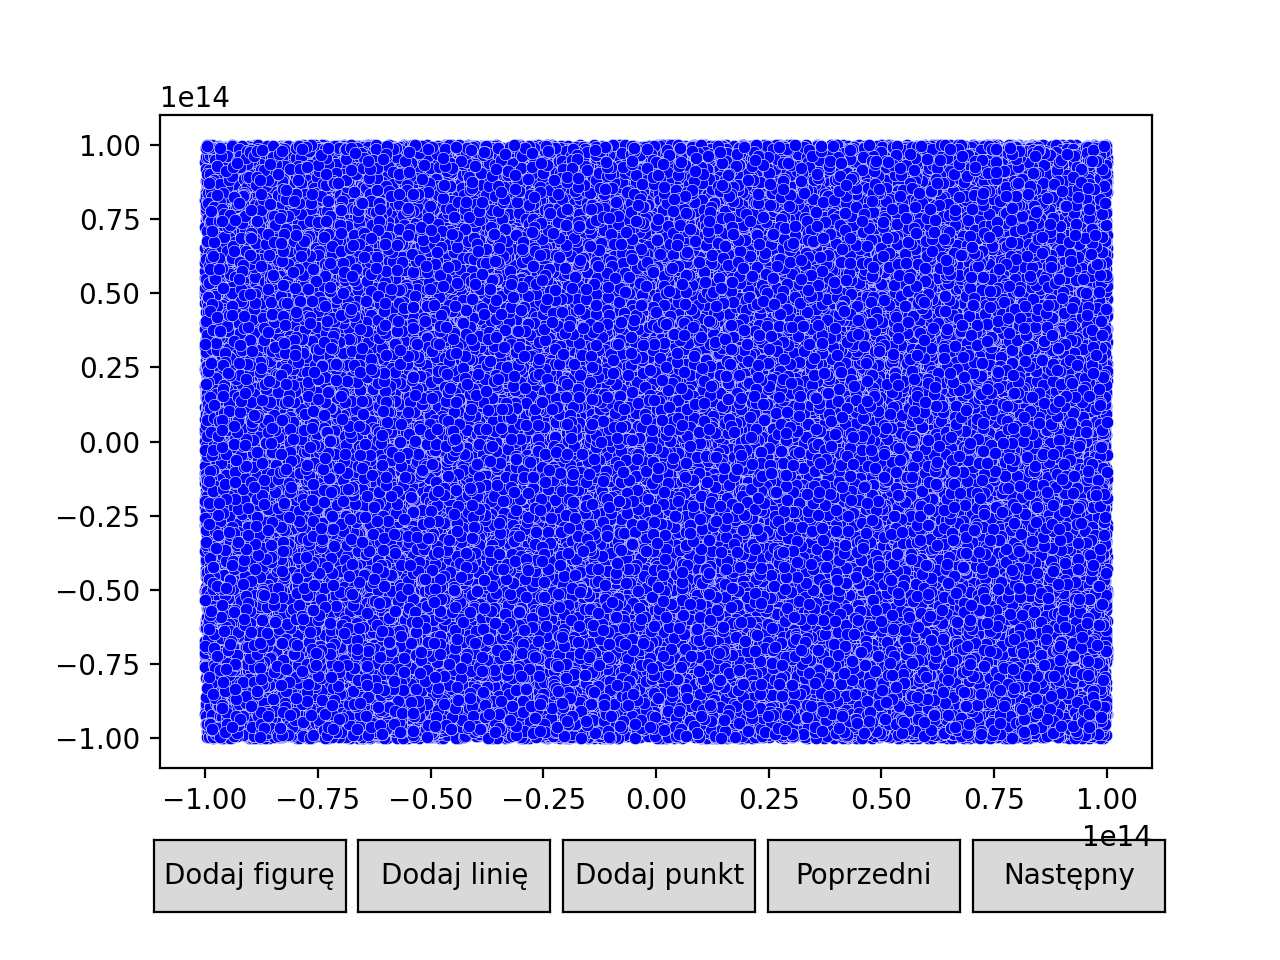

In [4]:
z = 10**5
a,b = -10**14,10**14
x = np.random.uniform(a,b,z)
y = np.random.uniform(a,b,z)
tab2 = []
# points = PointsCollection(tab2,gridsize=50,bins="log",cmap=plt.colormaps["Greens"],linewidths=0.05,edgecolors="black")
points = PointsCollection(tab2,c="blue",s=20,edgecolors="white",linewidths=0.2)
for i in range(len(x)):
    tab2.append((x[i],y[i]))
scenes=[Scene([points])]
plot4 = Plot(scenes = scenes,rect = "scatter")
plot4.draw()

#### c) 1000 losowych punktów leżących na okręgu o środku (0,0) i promieniu R=100

/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_4750/3508443624.py:123: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


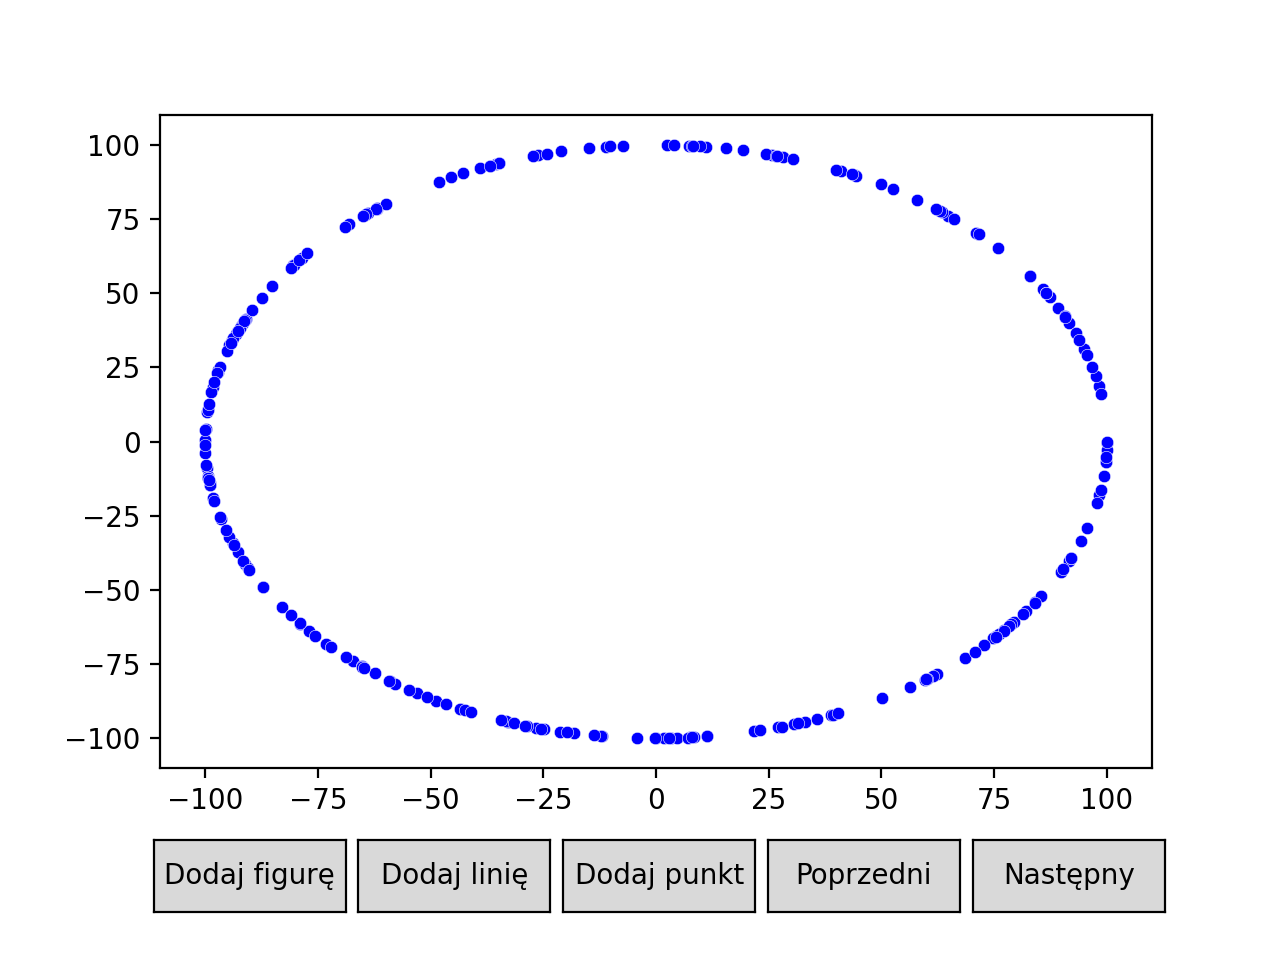

In [5]:
z = 250
a,b = 0,4
t = np.random.uniform(a,b,z)
tab3 = []
points = PointsCollection(tab3,c="blue",s=20,edgecolors="white",linewidths=0.2)
for i in range(len(t)):
    tab3.append((np.cos(np.pi*t[i]/2)*100,np.sin(np.pi*t[i]/2)*100))
scenes=[Scene([points])]
plot5 = Plot(scenes = scenes,rect = "scatter")
plot5.draw()

#### d) 1000 losowych punktów o współrzędnych z przedziału [-1000, 1000] leżących na prostej wyznaczonej przez wektor (a, b), przyjmij a = [-1.0, 0.0], b = [1.0, 0.1]

/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_4750/3508443624.py:123: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


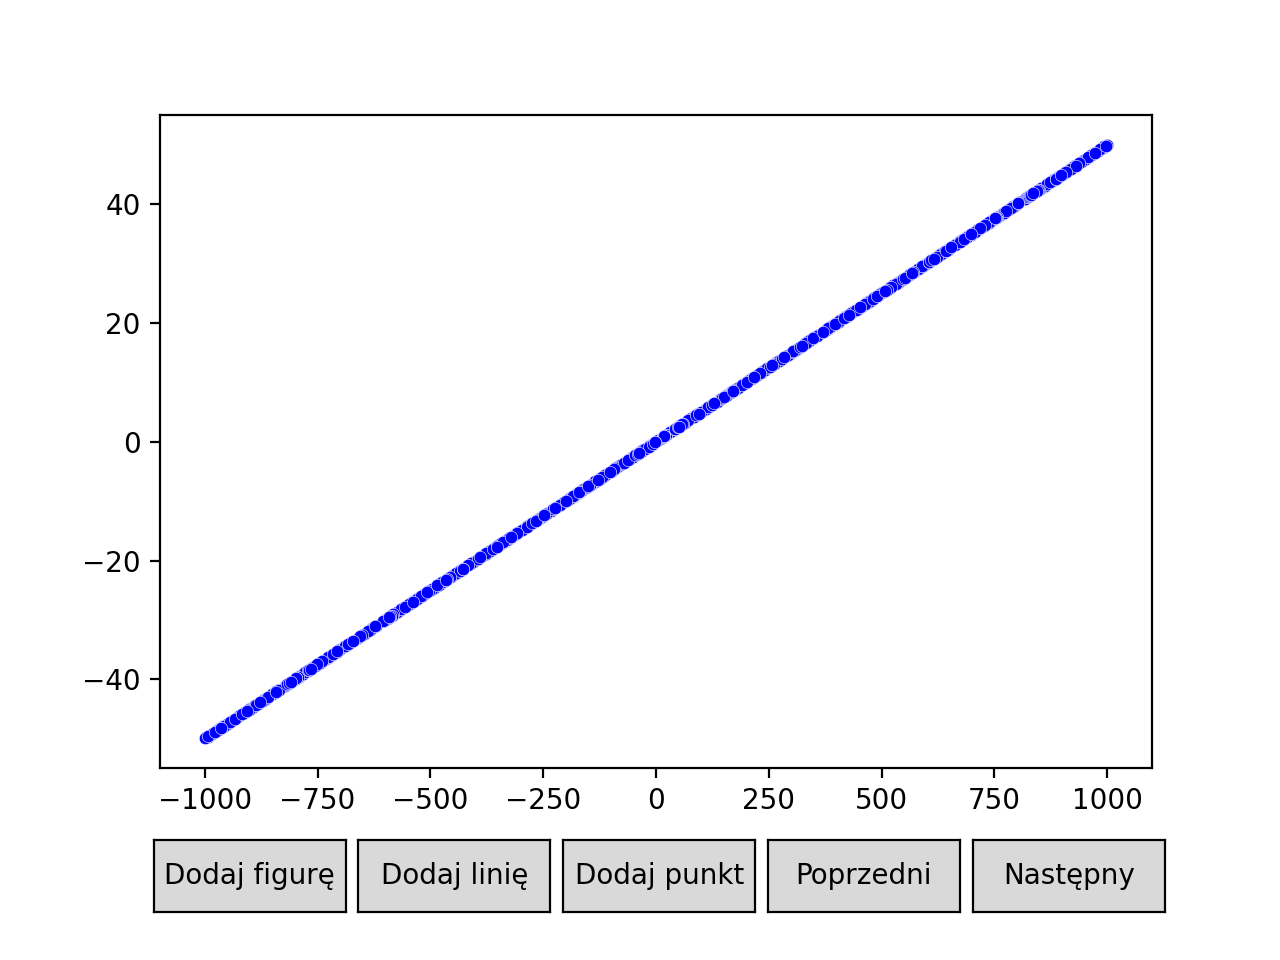

In [6]:
z = 1000
a,b = -499.5,500.5
x = np.random.uniform(a,b,z)
tab4 = []
a = [-1.0, 0.0]
b = [1.0, 0.1]
wek = [b[0]-a[0],b[1]-a[1]]
points = PointsCollection(tab4,c="blue",s=20,edgecolors="white",linewidths=0.2)
for i in range(z):
    tab4.append((a[0]+x[i]*wek[0],a[1]+x[i]*wek[1]))
scenes=[Scene([points])]
plot6 = Plot(scenes = scenes,rect = "scatter")
plot6.draw()

In [65]:
def det1(a,b,c):
    deta = a[0]*b[1] + b[0]*c[1] + a[1]*c[0]
    detb = c[0]*b[1] + c[1]*a[0] + b[0]*a[1]
    det = deta-detb
    return det
def det2(a,b,c):
    deta = (a[0]-c[0])*(b[1]-c[1])
    detb = (b[0]-c[0])*(a[1]-c[1])
    det = deta - detb
    return det

In [419]:
tab = [tab1,tab2,tab3,tab4]
def generate3x3(tab,add,add2,number=1):
    for j in range(len(tab)):
        for i in range(len(tab[j])):
            c = (tab[j][i][0],tab[j][i][1])
            wyz = det1(a,b,c)
            if wyz > between:
                if add2:
                    left[j].append(c)
                if add:
                    tab_new[j][i][number][1].append(1)
            elif wyz < -between:
                if add2:
                    right[j].append(c)
                if add:
                    tab_new[j][i][number][1].append(-1)
            else:
                if add2:
                    linear[j].append(c)
                if add:
                    tab_new[j][i][number][1].append(0)
def generate2x2(tab,add,add2,number=1):
    for j in range(len(tab)):
        for i in range(len(tab[j])):
            c = (tab[j][i][0],tab[j][i][1])
            wyz = det2(a,b,c)
            if wyz > between:
                if add2:
                    left[j].append(c)
                if add:
                    tab_new[j][i][number][0].append(1)
            elif wyz < -between:
                if add2:
                    right[j].append(c)
                if add:
                    tab_new[j][i][number][0].append(-1)
            else:
                if add2:
                    linear[j].append(c)
                if add:
                    tab_new[j][i][number][0].append(0)
            
def generatenp3x3(tab,add,add2,number=1):
    for j in range(len(tab)):
        for i in range(len(tab[j])):
            x,y = tab[j][i][0],tab[j][i][1]
            c = (x,y)
            arr = np.array([[a[0],a[1],1],[b[0],b[1],1],[x,y,1]])
            wyz = np.linalg.det(arr)
            if wyz > between:
                if add2:
                    left[j].append(c)
                if add:
                    tab_new[j][i][number][2].append(1)
            elif wyz < -between:
                if add2:
                    right[j].append(c)
                if add:
                    tab_new[j][i][number][2].append(-1)
            else:
                if add2:
                    linear[j].append(c)
                if add:
                    tab_new[j][i][number][2].append(0)
def generatenp2x2(tab,add,add2,number=1):
     for j in range(len(tab)):
        for i in range(len(tab[j])):
            x,y = tab[j][i][0],tab[j][i][1]
            c = (x,y)
            arr = np.array([[a[0]-c[0],a[1]-c[1]],[b[0]-c[0],b[1]-c[1]]])
            wyz = np.linalg.det(arr)
            if wyz > between:
                if add2:
                    left[j].append(c)
                if add:
                    tab_new[j][i][number][3].append(1)
            elif wyz < -between:
                if add2:
                    right[j].append(c)
                if add:
                    tab_new[j][i][number][3].append(-1)
            else:
                if add2:
                    linear[j].append(c)
                if add:
                    tab_new[j][i][number][3].append(0)

between = 0
a,b = (-1.0,0.0),(1.0,0.1)
line1 = [(-1.0,0.0),(1.0,0.1)]
# line1 = [(2,1),(3,7)]
x1,x2 = -10**3,10**3
y1,y2 = 0.05*x1 + 0.05,0.05*x2 + 0.05 
lines1 = [(x1,y1),(x2,y2)]
x1,x2 = -10**14,10**14
y1,y2 = 0.05*x1 + 0.05,0.05*x2 + 0.05
lines2 = [(x1,y1),(x2,y2)]
x1,x2 = -100,100
y1,y2 = 0.05*x1 + 0.05,0.05*x2 + 0.05
lines3 = [(x1,y1),(x2,y2)]
def to_table(left,linear,right):
    for i in range(len(left)):
        str_ = "Set:" + str(i) + " " + str(len(left[i]))
        for k1 in range(10-len(str(len(left[i])))):
            str_+=" "
        str_ +=  str(len(linear[i]))
        for k1 in range(12-len(str(len(linear[i])))):
            str_+=" "
        str_ += str(len(right[i]))
        print(str_)

In [420]:
tab_new = [[],[],[],[]]
for i in range(len(tab)):
    for j in range(len(tab[i])):
        t = [tab[i][j]]
        for z in range(4):
            t.append([[],[],[],[]])
        tab_new[i].append(t)
between,nn = 10**-14,1
generate2x2(tab,True,False,nn)
generate3x3(tab,True,False,nn)
generatenp2x2(tab,True,False,nn)
generatenp3x3(tab,True,False,nn)
between,nn = 10**-12,2
generate2x2(tab,True,False,nn)
generate3x3(tab,True,False,nn)
generatenp2x2(tab,True,False,nn)
generatenp3x3(tab,True,False,nn)
between,nn = 10**-10,3
generate2x2(tab,True,False,nn)
generate3x3(tab,True,False,nn)
generatenp2x2(tab,True,False,nn)
generatenp3x3(tab,True,False,nn)
between,nn = 10**-8,4
generate2x2(tab,True,False,nn)
generate3x3(tab,True,False,nn)
generatenp2x2(tab,True,False,nn)
generatenp3x3(tab,True,False,nn)

In [421]:
print("Kolejne tablice to matrix 2x2, matrix 3x3, matrix numpay 3x3 , matrix numpay 2x2")
print("                 Punkt                10^-14       10^-12    10^-10    10^-8")
for i in range(5):
    tb_ = tab_new[0][i]
    string = str(tb_[0]) + ","
    for j in range(1,len(tb_)):
        string += "(" + str(tb_[j][0][0])  +"," + str(tb_[j][1][0]) +"," + str(tb_[j][2][0]) +"," + str(tb_[j][3][0])+ ")"
    print(string)
print("                 Punkt                10^-14       10^-12    10^-10    10^-8")
for i in range(5):
    tb_ = tab_new[1][i]
    string = str(tb_[0]) + ","
    for j in range(1,len(tb_)):
        string += "(" + str(tb_[j][0][0])  +"," + str(tb_[j][1][0]) +"," + str(tb_[j][2][0]) +"," + str(tb_[j][3][0])+ ")"
    print(string)
print("                 Punkt                10^-14       10^-12    10^-10    10^-8")
for i in range(5):
    tb_ = tab_new[2][i]
    string = str(tb_[0]) + ","
    for j in range(1,len(tb_)):
        string += "(" + str(tb_[j][0][0])  +"," + str(tb_[j][1][0]) +"," + str(tb_[j][2][0]) +"," + str(tb_[j][3][0])+ ")"
    print(string)
print("                 Punkt                10^-14       10^-12    10^-10    10^-8")
for i in range(5):
    tb_ = tab_new[3][i]
    string = str(tb_[0]) + ","
    for j in range(1,len(tb_)):
        string += "(" + str(tb_[j][0][0])  +"," + str(tb_[j][1][0]) +"," + str(tb_[j][2][0]) +"," + str(tb_[j][3][0])+ ")"
    print(string)

Kolejne tablice to matrix 2x2, matrix 3x3, matrix numpay 3x3 , matrix numpay 2x2
                 Punkt                10^-14       10^-12    10^-10    10^-8
(383.944890284577, -977.2505612482809),(-1,-1,-1,-1)(-1,-1,-1,-1)(-1,-1,-1,-1)(-1,-1,-1,-1)
(484.3016989654416, 878.3875792519711),(1,1,1,1)(1,1,1,1)(1,1,1,1)(1,1,1,1)
(932.158259147619, 14.070560113649321),(-1,-1,-1,-1)(-1,-1,-1,-1)(-1,-1,-1,-1)(-1,-1,-1,-1)
(-183.5398833982647, 775.8155535341004),(1,1,1,1)(1,1,1,1)(1,1,1,1)(1,1,1,1)
(260.0275788990632, 314.42566998135953),(1,1,1,1)(1,1,1,1)(1,1,1,1)(1,1,1,1)
                 Punkt                10^-14       10^-12    10^-10    10^-8
(7156975058715.969, -40411588513231.85),(-1,-1,-1,-1)(-1,-1,-1,-1)(-1,-1,-1,-1)(-1,-1,-1,-1)
(-13219233900958.203, 43387385739829.59),(1,1,1,1)(1,1,1,1)(1,1,1,1)(1,1,1,1)
(-99240335045315.78, -27685850097775.266),(-1,-1,-1,-1)(-1,-1,-1,-1)(-1,-1,-1,-1)(-1,-1,-1,-1)
(-18270489336224.125, 34471373573280.844),(1,1,1,1)(1,1,1,1)(1,1,1,1)(1,1,1,1)
(-7738

In [422]:
sets = [[],[],[],[]]
for i in range(4):
    for j in range(4):
            sets[i].append([[0,0,0],[0,0,0],[0,0,0],[0,0,0]])
for i in range(4):
    for j in range(len(tab_new[i])):
        for k in range(1,5):
            for f in range(4):
                number_ = tab_new[i][j][k][f][0]
                sets[i][k-1][f][number_+1]+=1
for i in range(4):
    for j in range(4):
        for k in range(4):
            sets[i][j][k] = list(reversed(sets[i][j][k])) 

In [423]:
print("         Matrix 2x2           Matrix 3x3         Numpy 3x3          Numpy 2x2 ")
print("      Lewo Środek Prawo")
for i in range(4):
    print("Set:" + str(i))
    print("d^-14",sets[i][0])
    print("d^-12",sets[i][1])
    print("d^-10",sets[i][2])
    print("d^-8",sets[i][3])

         Matrix 2x2           Matrix 3x3         Numpy 3x3          Numpy 2x2 
      Lewo Środek Prawo
Set:0
d^-14 [[49734, 0, 50266], [49734, 0, 50266], [49734, 0, 50266], [49734, 0, 50266]]
d^-12 [[49734, 0, 50266], [49734, 0, 50266], [49734, 0, 50266], [49734, 0, 50266]]
d^-10 [[49734, 0, 50266], [49734, 0, 50266], [49734, 0, 50266], [49734, 0, 50266]]
d^-8 [[49734, 0, 50266], [49734, 0, 50266], [49734, 0, 50266], [49734, 0, 50266]]
Set:1
d^-14 [[50057, 8, 49935], [50061, 0, 49939], [50061, 0, 49939], [50061, 0, 49939]]
d^-12 [[50057, 8, 49935], [50061, 0, 49939], [50061, 0, 49939], [50061, 0, 49939]]
d^-10 [[50057, 8, 49935], [50061, 0, 49939], [50061, 0, 49939], [50061, 0, 49939]]
d^-8 [[50057, 8, 49935], [50061, 0, 49939], [50061, 0, 49939], [50061, 0, 49939]]
Set:2
d^-14 [[119, 0, 131], [119, 0, 131], [119, 0, 131], [119, 0, 131]]
d^-12 [[119, 0, 131], [119, 0, 131], [119, 0, 131], [119, 0, 131]]
d^-10 [[119, 0, 131], [119, 0, 131], [119, 0, 131], [119, 0, 131]]
d^-8 [[119, 0, 1

## Generowanie wykresów, float64, tolerancja 0 

/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_4750/3508443624.py:123: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


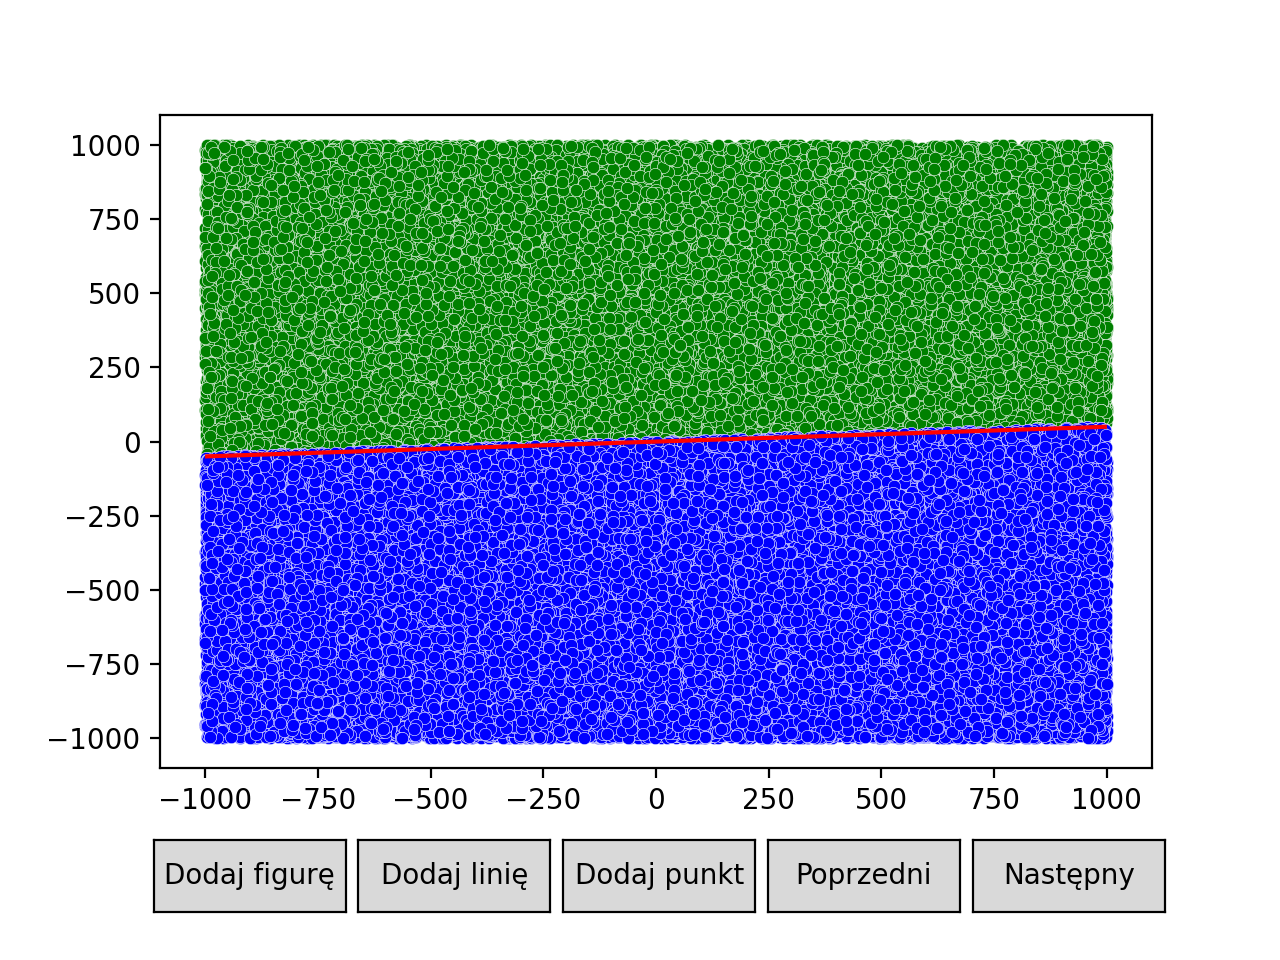

          Matrix własny 2x2
      Lewo      Środek      Prawo
Set:0 49734     0           50266
Set:1 50057     8           49935
Set:2 119       0           131
Set:3 140       716         144


In [346]:
between = 0
left,right,linear = [[],[],[],[]],[[],[],[],[]],[[],[],[],[]]
generate2x2(tab,False,True)
Pointsy1 = [PointsCollection(left[0], color='green',s=20,edgecolors="white",linewidths=0.2),PointsCollection(right[0], color='blue',s=20,edgecolors="white",linewidths=0.2),PointsCollection(linear[0], color='red',s=20,edgecolors="white",linewidths=0.2)]
Pointsy2 = [PointsCollection(left[1], color='green',s=20,edgecolors="white",linewidths=0.2),PointsCollection(right[1], color='blue',s=20,edgecolors="white",linewidths=0.2),PointsCollection(linear[1], color='red',s=20,edgecolors="white",linewidths=0.2)]
Pointsy3 = [PointsCollection(left[2], color='green',s=20,edgecolors="white",linewidths=0.2),PointsCollection(right[2], color='blue',s=20,edgecolors="white",linewidths=0.2),PointsCollection(linear[2], color='red',s=20,edgecolors="white",linewidths=0.2)]
Pointsy4 = [PointsCollection(left[3], color='green',s=20,edgecolors="white",linewidths=0.2),PointsCollection(right[3], color='blue',s=20,edgecolors="white",linewidths=0.2),PointsCollection(linear[3], color='red',s=20,edgecolors="white",linewidths=0.2)]
scenes=[Scene(Pointsy1,[LinesCollection([lines1],color='red')]),
        Scene(Pointsy2,[LinesCollection([lines2],color='red')]),
        Scene(Pointsy3,[LinesCollection([lines3],color='red')]),
        Scene(Pointsy4,[LinesCollection([lines1],color='red')])]
plot7 = Plot(scenes = scenes)
plot7.draw()
print("          Matrix własny 2x2")
print('      Lewo      Środek      Prawo')
to_table(left,linear,right)
   

/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_4750/3508443624.py:123: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


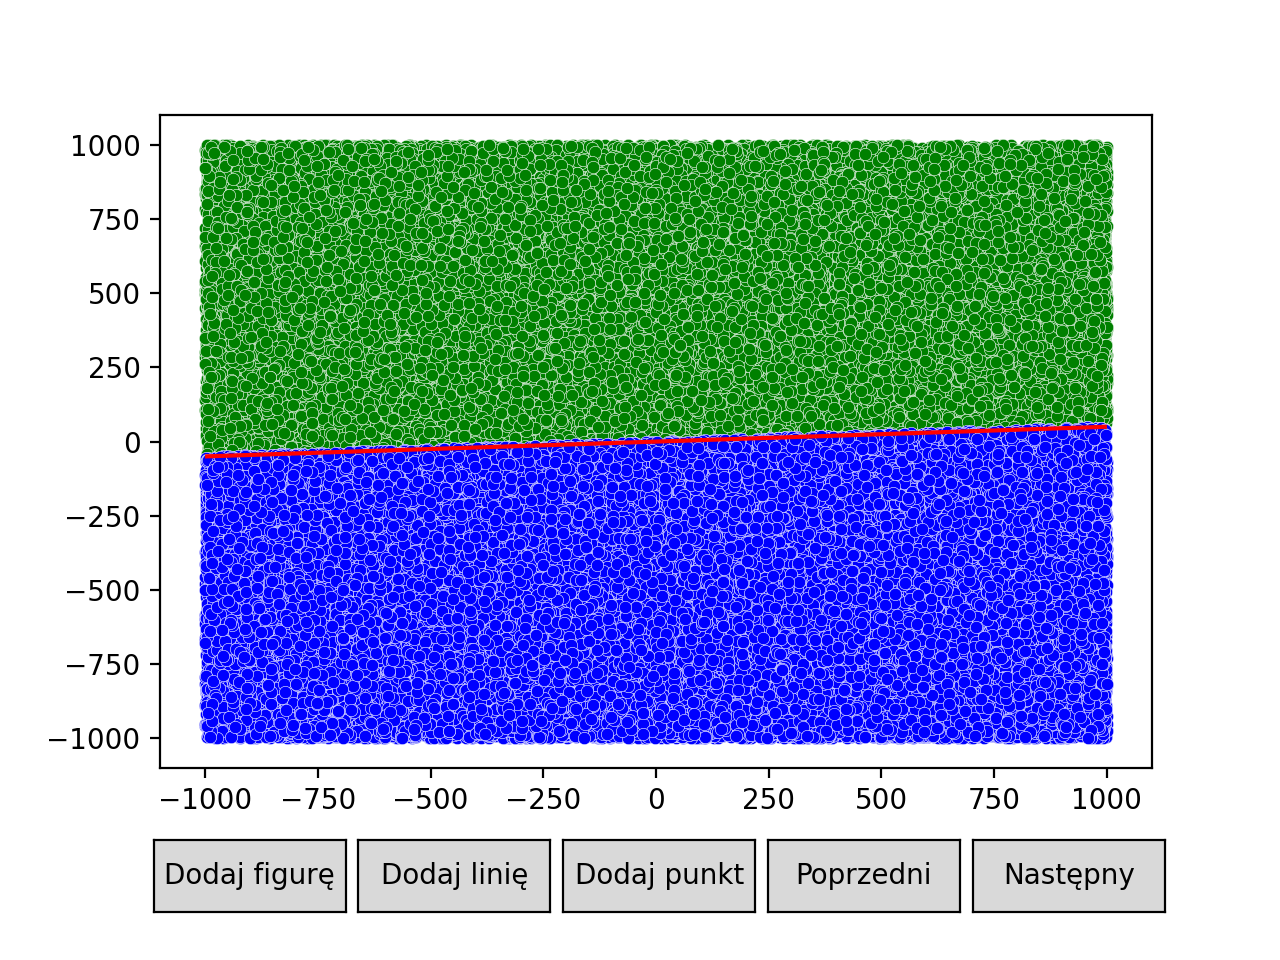

          Matrix własny 3x3
      Lewo      Środek      Prawo
Set:0 49734     0           50266
Set:1 50061     0           49939
Set:2 119       0           131
Set:3 267       362         371


In [212]:
left,right,linear = [[],[],[],[]],[[],[],[],[]],[[],[],[],[]]
generate3x3(tab,False,True)
Pointsy1 = [PointsCollection(left[0], color='green',s=20,edgecolors="white",linewidths=0.2),PointsCollection(right[0], color='blue',s=20,edgecolors="white",linewidths=0.2),PointsCollection(linear[0], color='red',s=20,edgecolors="white",linewidths=0.2)]
Pointsy2 = [PointsCollection(left[1], color='green',s=20,edgecolors="white",linewidths=0.2),PointsCollection(right[1], color='blue',s=20,edgecolors="white",linewidths=0.2),PointsCollection(linear[1], color='red',s=20,edgecolors="white",linewidths=0.2)]
Pointsy3 = [PointsCollection(left[2], color='green',s=20,edgecolors="white",linewidths=0.2),PointsCollection(right[2], color='blue',s=20,edgecolors="white",linewidths=0.2),PointsCollection(linear[2], color='red',s=20,edgecolors="white",linewidths=0.2)]
Pointsy4 = [PointsCollection(left[3], color='green',s=20,edgecolors="white",linewidths=0.2),PointsCollection(right[3], color='blue',s=20,edgecolors="white",linewidths=0.2),PointsCollection(linear[3], color='red',s=20,edgecolors="white",linewidths=0.2)]
scenes=[Scene(Pointsy1,[LinesCollection([lines1],color='red')]),
        Scene(Pointsy2,[LinesCollection([lines2],color='red')]),
        Scene(Pointsy3,[LinesCollection([lines3],color='red')]),
        Scene(Pointsy4,[LinesCollection([lines1],color='red')])]
plot7 = Plot(scenes = scenes)
plot7.draw()
print("          Matrix własny 3x3")
print('      Lewo      Środek      Prawo')
to_table(left,linear,right)

/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_4750/3508443624.py:123: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


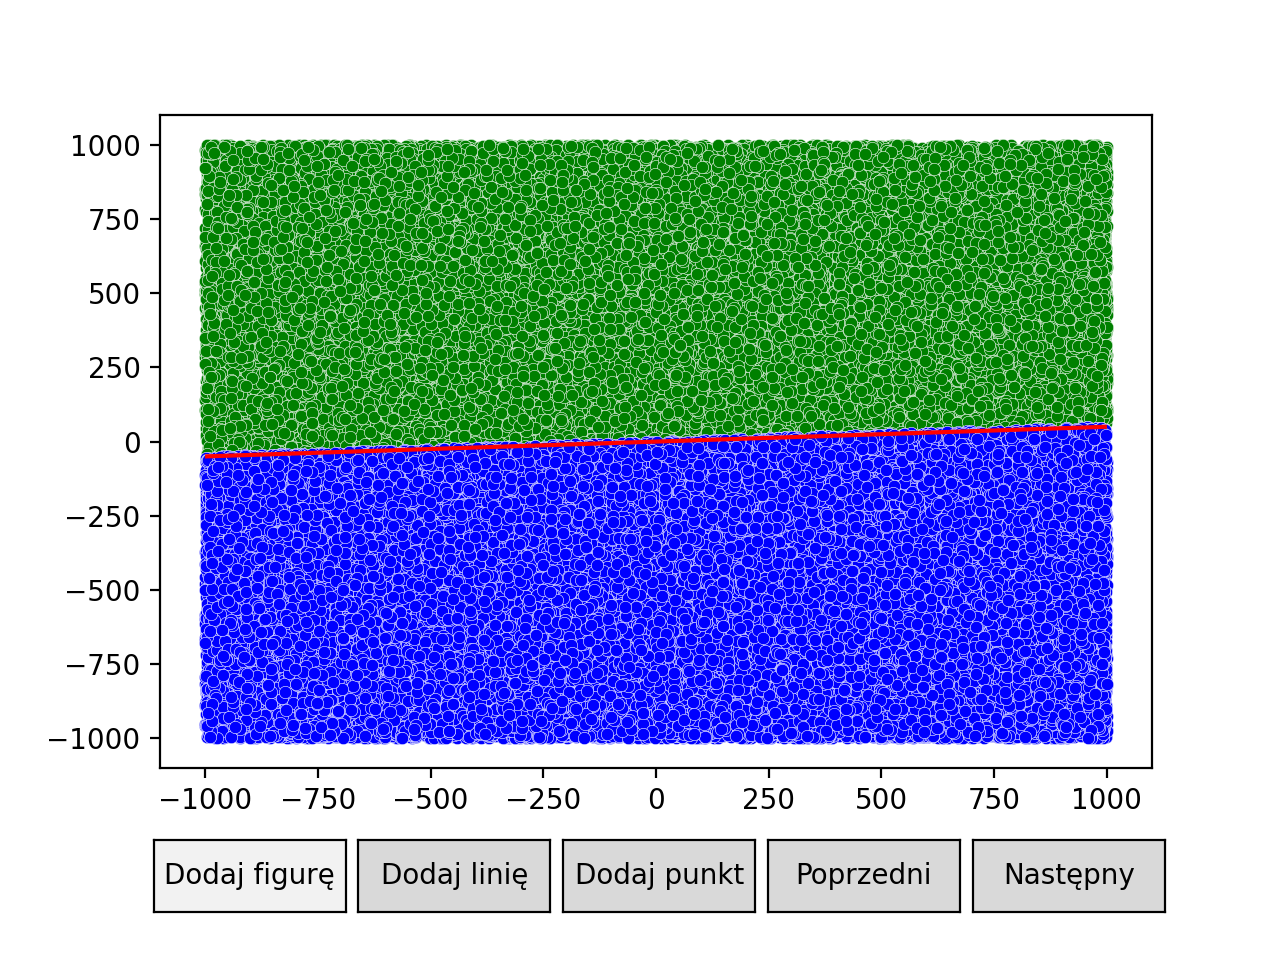

          Matrix numpy 2x2
      Lewo      Środek      Prawo
Set:0 49734     0           50266
Set:1 50061     0           49939
Set:2 119       0           131
Set:3 463       0           537


In [213]:
left,right,linear = [[],[],[],[]],[[],[],[],[]],[[],[],[],[]]
generatenp2x2(tab,False,True)
Pointsy1 = [PointsCollection(left[0], color='green',s=20,edgecolors="white",linewidths=0.2),PointsCollection(right[0], color='blue',s=20,edgecolors="white",linewidths=0.2),PointsCollection(linear[0], color='red',s=20,edgecolors="white",linewidths=0.2)]
Pointsy2 = [PointsCollection(left[1], color='green',s=20,edgecolors="white",linewidths=0.2),PointsCollection(right[1], color='blue',s=20,edgecolors="white",linewidths=0.2),PointsCollection(linear[1], color='red',s=20,edgecolors="white",linewidths=0.2)]
Pointsy3 = [PointsCollection(left[2], color='green',s=20,edgecolors="white",linewidths=0.2),PointsCollection(right[2], color='blue',s=20,edgecolors="white",linewidths=0.2),PointsCollection(linear[2], color='red',s=20,edgecolors="white",linewidths=0.2)]
Pointsy4 = [PointsCollection(left[3], color='green',s=20,edgecolors="white",linewidths=0.2),PointsCollection(right[3], color='blue',s=20,edgecolors="white",linewidths=0.2),PointsCollection(linear[3], color='red',s=20,edgecolors="white",linewidths=0.2)]
scenes=[Scene(Pointsy1,[LinesCollection([lines1],color='red')]),
        Scene(Pointsy2,[LinesCollection([lines2],color='red')]),
        Scene(Pointsy3,[LinesCollection([lines3],color='red')]),
        Scene(Pointsy4)]
plot7 = Plot(scenes = scenes)
plot7.draw()
print("          Matrix numpy 2x2")
print('      Lewo      Środek      Prawo')
to_table(left,linear,right)

/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_4750/3508443624.py:123: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


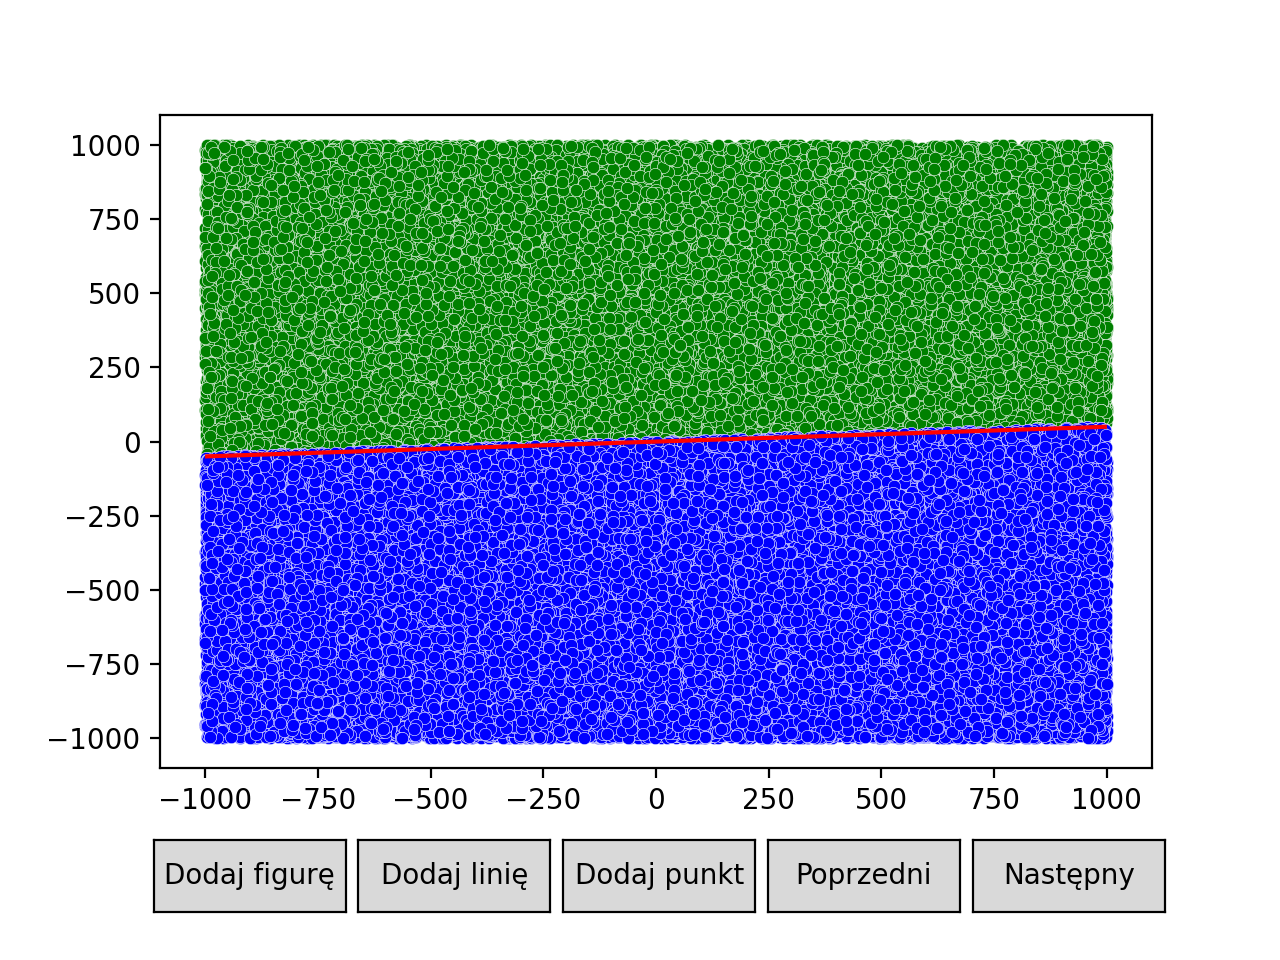

          Matrix numpy 3x3
      Lewo      Środek      Prawo
Set:0 49734     0           50266
Set:1 50061     0           49939
Set:2 119       0           131
Set:3 499       0           501


In [214]:
left,right,linear = [[],[],[],[]],[[],[],[],[]],[[],[],[],[]]
generatenp3x3(tab,False,True)
Pointsy1 = [PointsCollection(left[0], color='green',s=20,edgecolors="white",linewidths=0.2),PointsCollection(right[0], color='blue',s=20,edgecolors="white",linewidths=0.2),PointsCollection(linear[0], color='red',s=20,edgecolors="white",linewidths=0.2)]
Pointsy2 = [PointsCollection(left[1], color='green',s=20,edgecolors="white",linewidths=0.2),PointsCollection(right[1], color='blue',s=20,edgecolors="white",linewidths=0.2),PointsCollection(linear[1], color='red',s=20,edgecolors="white",linewidths=0.2)]
Pointsy3 = [PointsCollection(left[2], color='green',s=20,edgecolors="white",linewidths=0.2),PointsCollection(right[2], color='blue',s=20,edgecolors="white",linewidths=0.2),PointsCollection(linear[2], color='red',s=20,edgecolors="white",linewidths=0.2)]
Pointsy4 = [PointsCollection(left[3], color='green',s=20,edgecolors="white",linewidths=0.2),PointsCollection(right[3], color='blue',s=20,edgecolors="white",linewidths=0.2),PointsCollection(linear[3], color='red',s=20,edgecolors="white",linewidths=0.2)]
scenes=[Scene(Pointsy1,[LinesCollection([lines1],color='red')]),
        Scene(Pointsy2,[LinesCollection([lines2],color='red')]),
        Scene(Pointsy3,[LinesCollection([lines3],color='red')]),
        Scene(Pointsy4,[LinesCollection([lines1],color='red')])]
plot7 = Plot(scenes = scenes)
plot7.draw()
print("          Matrix numpy 3x3")
print('      Lewo      Środek      Prawo')
to_table(left,linear,right)

## Generowanie wykresów, float64, tolerancja 10^-14

/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_4750/3508443624.py:123: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


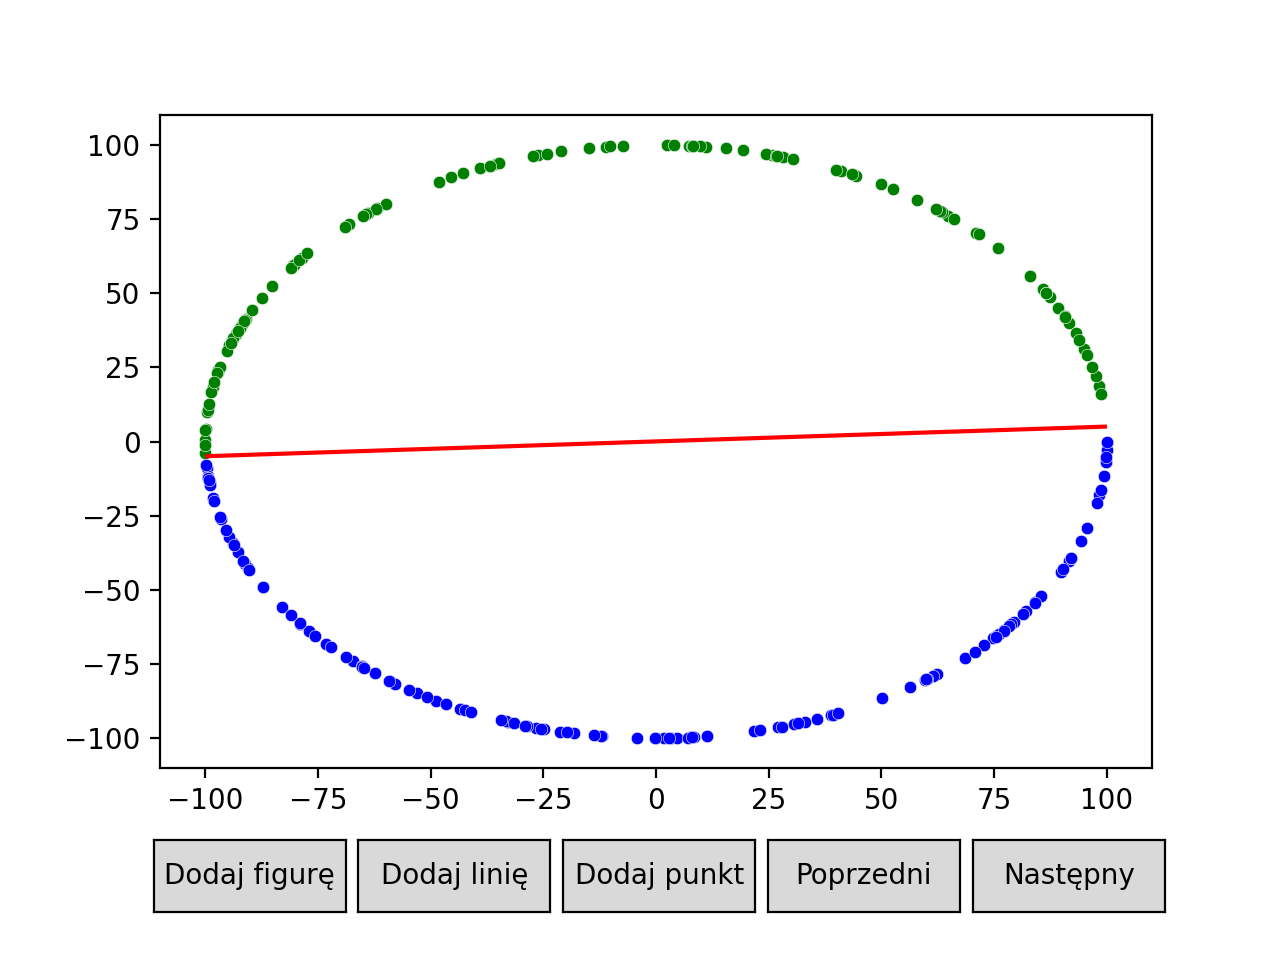

          Matrix własny 2x2
      Lewo      Środek      Prawo
Set:0 49734     0           50266
Set:1 50057     8           49935
Set:2 119       0           131
Set:3 134       726         140


In [251]:
between = 10**-14
left,right,linear = [[],[],[],[]],[[],[],[],[]],[[],[],[],[]]
generate2x2(tab,False,True)
Pointsy1 = [PointsCollection(left[0], color='green',s=20,edgecolors="white",linewidths=0.2),PointsCollection(right[0], color='blue',s=20,edgecolors="white",linewidths=0.2),PointsCollection(linear[0], color='red',s=20,edgecolors="white",linewidths=0.2)]
Pointsy2 = [PointsCollection(left[1], color='green',s=20,edgecolors="white",linewidths=0.2),PointsCollection(right[1], color='blue',s=20,edgecolors="white",linewidths=0.2),PointsCollection(linear[1], color='red',s=20,edgecolors="white",linewidths=0.2)]
Pointsy3 = [PointsCollection(left[2], color='green',s=20,edgecolors="white",linewidths=0.2),PointsCollection(right[2], color='blue',s=20,edgecolors="white",linewidths=0.2),PointsCollection(linear[2], color='red',s=20,edgecolors="white",linewidths=0.2)]
Pointsy4 = [PointsCollection(left[3], color='green',s=20,edgecolors="white",linewidths=0.2),PointsCollection(right[3], color='blue',s=20,edgecolors="white",linewidths=0.2),PointsCollection(linear[3], color='red',s=20,edgecolors="white",linewidths=0.2)]
scenes=[Scene(Pointsy1,[LinesCollection([lines1],color='red')]),
        Scene(Pointsy2,[LinesCollection([lines2],color='red')]),
        Scene(Pointsy3,[LinesCollection([lines3],color='red')]),
        Scene(Pointsy4,[LinesCollection([lines1],color='red')])]
plot7 = Plot(scenes = scenes)
plot7.draw()
print("          Matrix własny 2x2")
print('      Lewo      Środek      Prawo')
to_table(left,linear,right)

/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_4750/3508443624.py:123: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


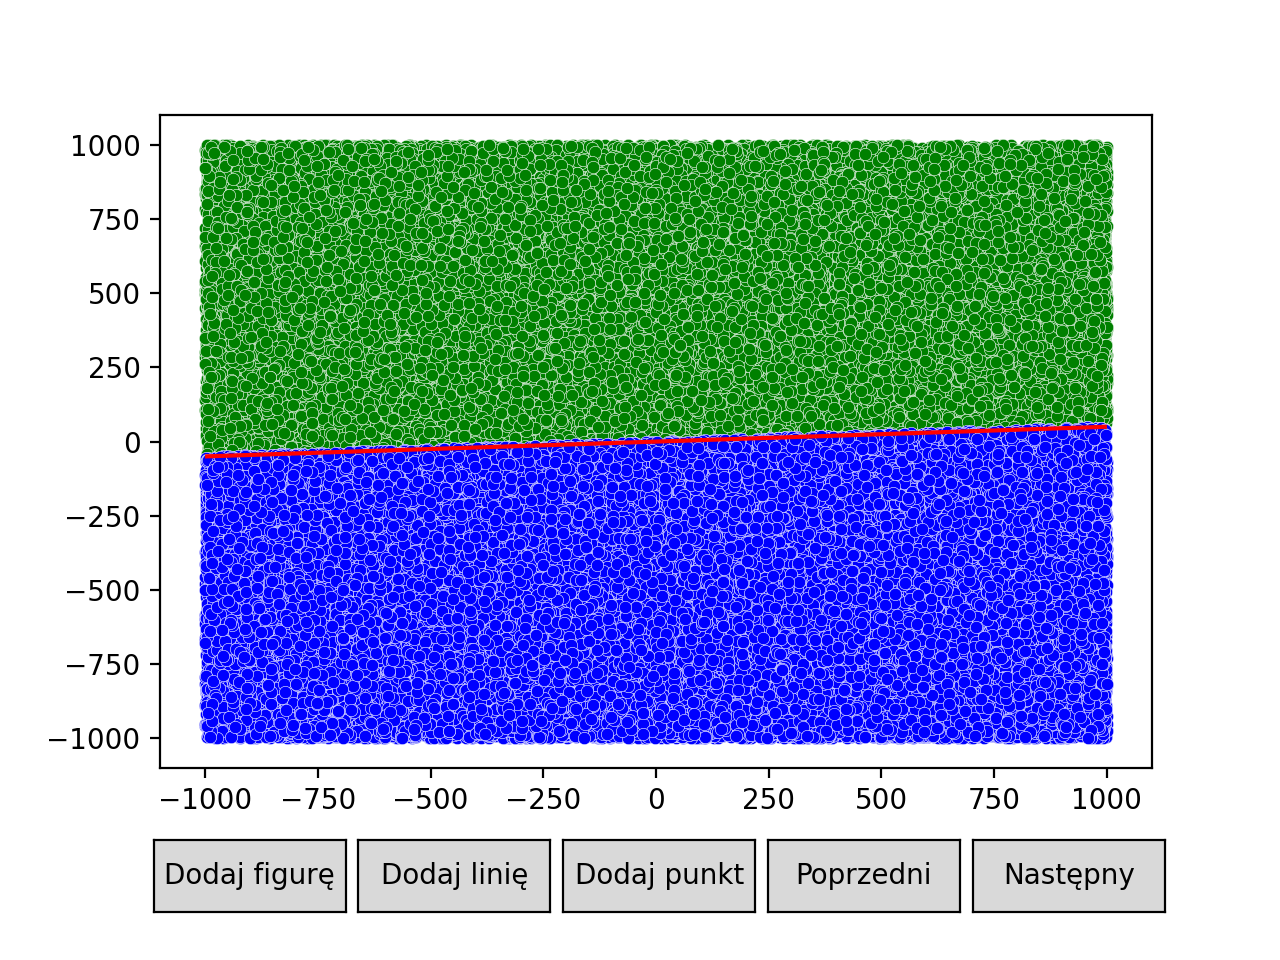

          Matrix własny 3x3
      Lewo      Środek      Prawo
Set:0 49734     0           50266
Set:1 50061     0           49939
Set:2 119       0           131
Set:3 0         1000        0


In [218]:
left,right,linear = [[],[],[],[]],[[],[],[],[]],[[],[],[],[]]
generate3x3(tab,False,True)
Pointsy1 = [PointsCollection(left[0], color='green',s=20,edgecolors="white",linewidths=0.2),PointsCollection(right[0], color='blue',s=20,edgecolors="white",linewidths=0.2),PointsCollection(linear[0], color='red',s=20,edgecolors="white",linewidths=0.2)]
Pointsy2 = [PointsCollection(left[1], color='green',s=20,edgecolors="white",linewidths=0.2),PointsCollection(right[1], color='blue',s=20,edgecolors="white",linewidths=0.2),PointsCollection(linear[1], color='red',s=20,edgecolors="white",linewidths=0.2)]
Pointsy3 = [PointsCollection(left[2], color='green',s=20,edgecolors="white",linewidths=0.2),PointsCollection(right[2], color='blue',s=20,edgecolors="white",linewidths=0.2),PointsCollection(linear[2], color='red',s=20,edgecolors="white",linewidths=0.2)]
Pointsy4 = [PointsCollection(left[3], color='green',s=20,edgecolors="white",linewidths=0.2),PointsCollection(right[3], color='blue',s=20,edgecolors="white",linewidths=0.2),PointsCollection(linear[3], color='red',s=20,edgecolors="white",linewidths=0.2)]
scenes=[Scene(Pointsy1,[LinesCollection([lines1],color='red')]),
        Scene(Pointsy2,[LinesCollection([lines2],color='red')]),
        Scene(Pointsy3,[LinesCollection([lines3],color='red')]),
        Scene(Pointsy4,[LinesCollection([lines1],color='red')])]
plot7 = Plot(scenes = scenes)
plot7.draw()
print("          Matrix własny 3x3")
print('      Lewo      Środek      Prawo')
to_table(left,linear,right)

/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_4750/3508443624.py:123: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


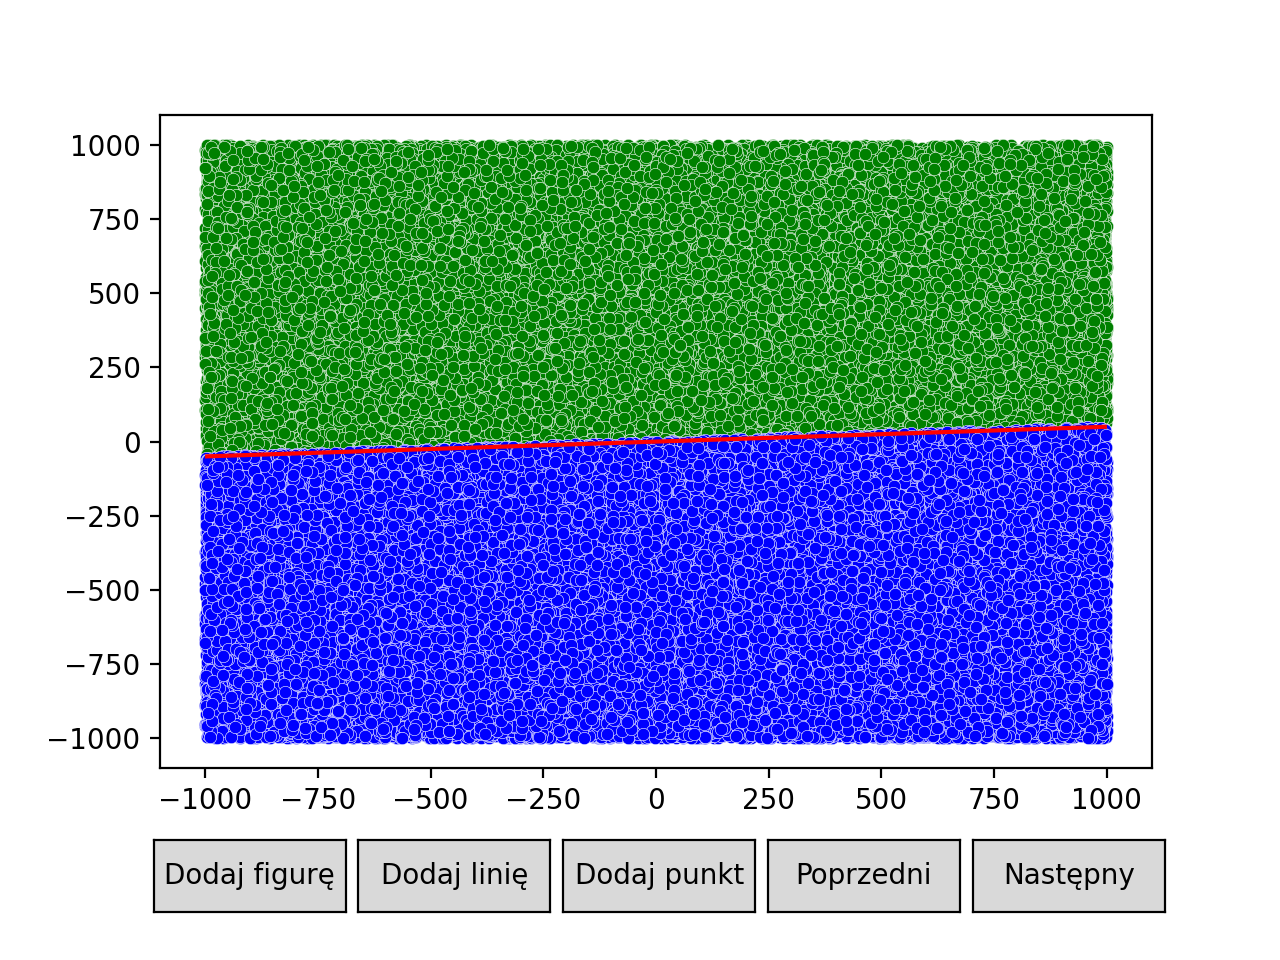

          Matrix numpy 2x2
      Lewo      Środek      Prawo
Set:0 49734     0           50266
Set:1 50061     0           49939
Set:2 119       0           131
Set:3 424       84          492


In [219]:
left,right,linear = [[],[],[],[]],[[],[],[],[]],[[],[],[],[]]
generatenp2x2(tab,False,True)
Pointsy1 = [PointsCollection(left[0], color='green',s=20,edgecolors="white",linewidths=0.2),PointsCollection(right[0], color='blue',s=20,edgecolors="white",linewidths=0.2),PointsCollection(linear[0], color='red',s=20,edgecolors="white",linewidths=0.2)]
Pointsy2 = [PointsCollection(left[1], color='green',s=20,edgecolors="white",linewidths=0.2),PointsCollection(right[1], color='blue',s=20,edgecolors="white",linewidths=0.2),PointsCollection(linear[1], color='red',s=20,edgecolors="white",linewidths=0.2)]
Pointsy3 = [PointsCollection(left[2], color='green',s=20,edgecolors="white",linewidths=0.2),PointsCollection(right[2], color='blue',s=20,edgecolors="white",linewidths=0.2),PointsCollection(linear[2], color='red',s=20,edgecolors="white",linewidths=0.2)]
Pointsy4 = [PointsCollection(left[3], color='green',s=20,edgecolors="white",linewidths=0.2),PointsCollection(right[3], color='blue',s=20,edgecolors="white",linewidths=0.2),PointsCollection(linear[3], color='red',s=20,edgecolors="white",linewidths=0.2)]
scenes=[Scene(Pointsy1,[LinesCollection([lines1],color='red')]),
        Scene(Pointsy2,[LinesCollection([lines2],color='red')]),
        Scene(Pointsy3,[LinesCollection([lines3],color='red')]),
        Scene(Pointsy4)]
plot7 = Plot(scenes = scenes)
plot7.draw()
print("          Matrix numpy 2x2")
print('      Lewo      Środek      Prawo')
to_table(left,linear,right)

/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_4750/3508443624.py:123: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


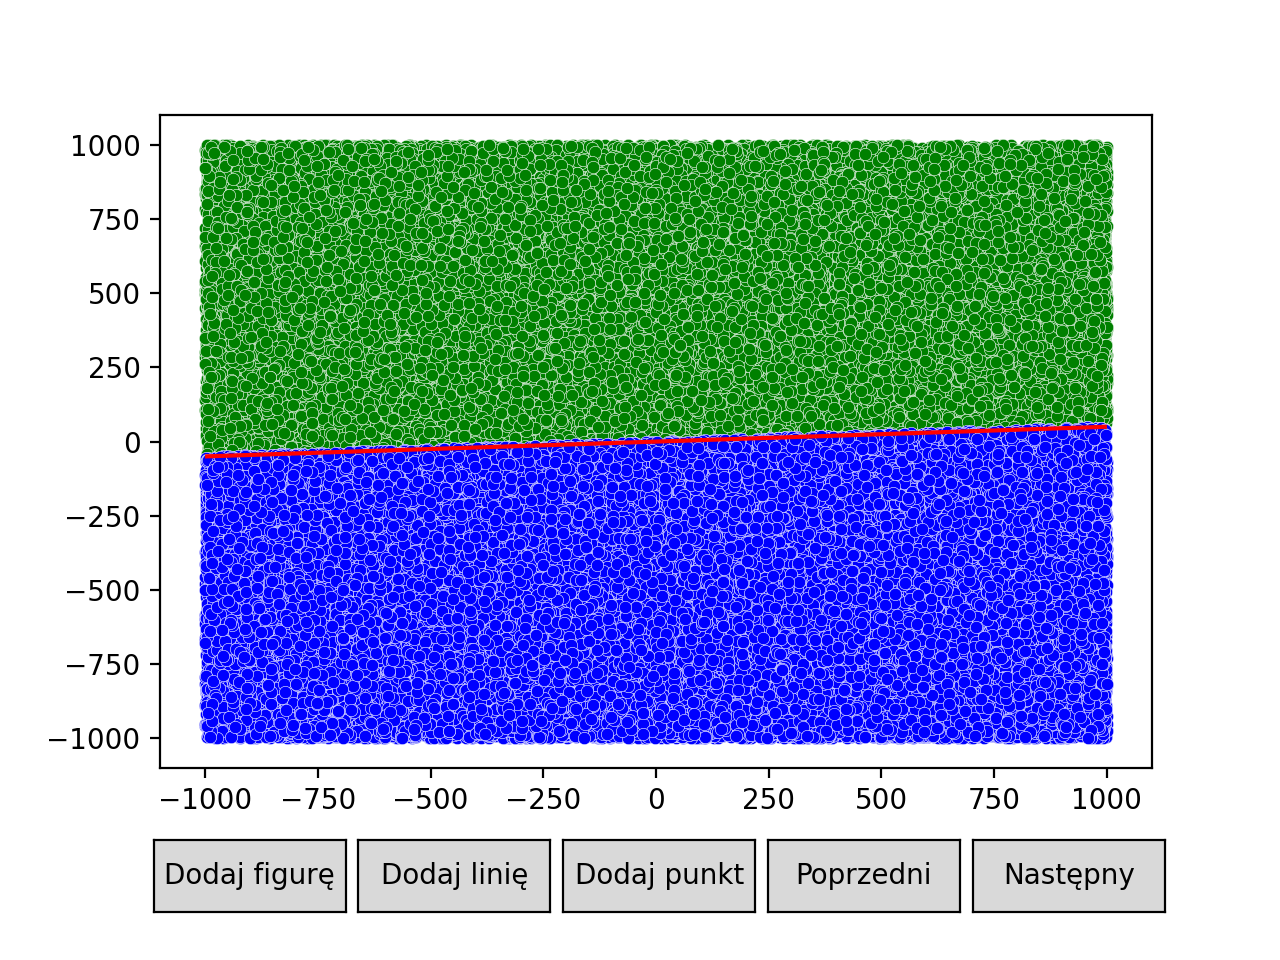

          Matrix numpy 3x3
      Lewo      Środek      Prawo
Set:0 49734     0           50266
Set:1 50061     0           49939
Set:2 119       0           131
Set:3 47        910         43


In [220]:
left,right,linear = [[],[],[],[]],[[],[],[],[]],[[],[],[],[]]
generatenp3x3(tab,False,True)
Pointsy1 = [PointsCollection(left[0], color='green',s=20,edgecolors="white",linewidths=0.2),PointsCollection(right[0], color='blue',s=20,edgecolors="white",linewidths=0.2),PointsCollection(linear[0], color='red',s=20,edgecolors="white",linewidths=0.2)]
Pointsy2 = [PointsCollection(left[1], color='green',s=20,edgecolors="white",linewidths=0.2),PointsCollection(right[1], color='blue',s=20,edgecolors="white",linewidths=0.2),PointsCollection(linear[1], color='red',s=20,edgecolors="white",linewidths=0.2)]
Pointsy3 = [PointsCollection(left[2], color='green',s=20,edgecolors="white",linewidths=0.2),PointsCollection(right[2], color='blue',s=20,edgecolors="white",linewidths=0.2),PointsCollection(linear[2], color='red',s=20,edgecolors="white",linewidths=0.2)]
Pointsy4 = [PointsCollection(left[3], color='green',s=20,edgecolors="white",linewidths=0.2),PointsCollection(right[3], color='blue',s=20,edgecolors="white",linewidths=0.2),PointsCollection(linear[3], color='red',s=20,edgecolors="white",linewidths=0.2)]
scenes=[Scene(Pointsy1,[LinesCollection([lines1],color='red')]),
        Scene(Pointsy2,[LinesCollection([lines2],color='red')]),
        Scene(Pointsy3,[LinesCollection([lines3],color='red')]),
        Scene(Pointsy4,[LinesCollection([lines1],color='red')])]
plot7 = Plot(scenes = scenes)
plot7.draw()
print("          Matrix numpy 3x3")
print('      Lewo      Środek      Prawo')
to_table(left,linear,right)

### Porównywanie punktów między precyzjami i użytymi znacznikami

In [347]:
all_points = []
for i in range(16):
    all_points.append([[],[],[],[]])
for k1 in range(4):
    for k2 in range(4):
        for i in range(4):
            for j in range(len(tab_new[i])):
                temp = tab_new[i][j]
                if temp[1][k1] != temp[2][k2]:
                    all_points[k1*4+k2][i].append(temp[0])

/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_4750/3508443624.py:123: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


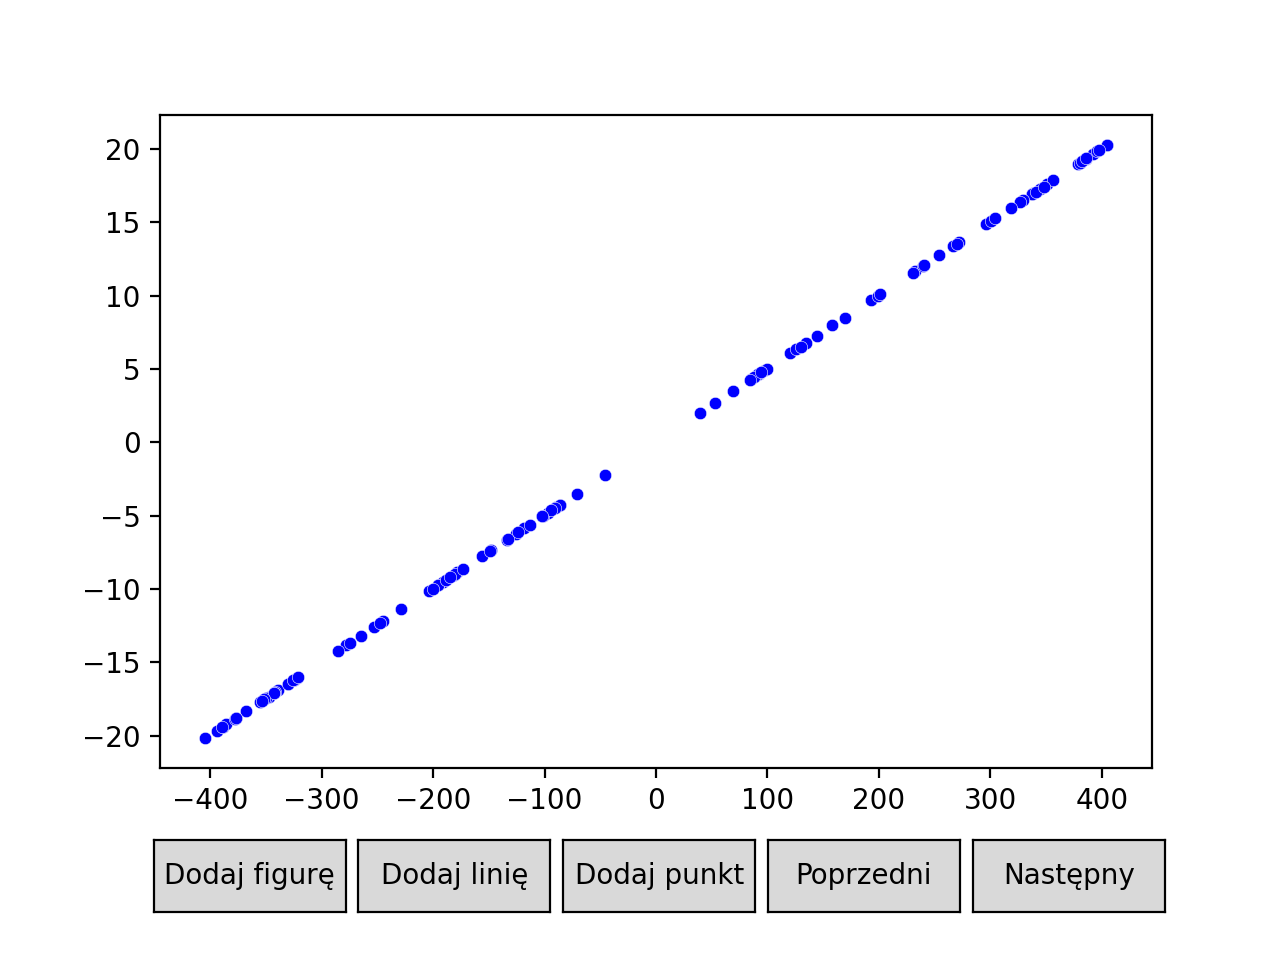

In [338]:
scenes=[]
for i in range(4):
    scenes.append(Scene([PointsCollection(all_points[0][i], color='blue',s=20,edgecolors="white",linewidths=0.2)]))
plot7 = Plot(scenes = scenes)
plot7.draw()

/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_4750/3508443624.py:123: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


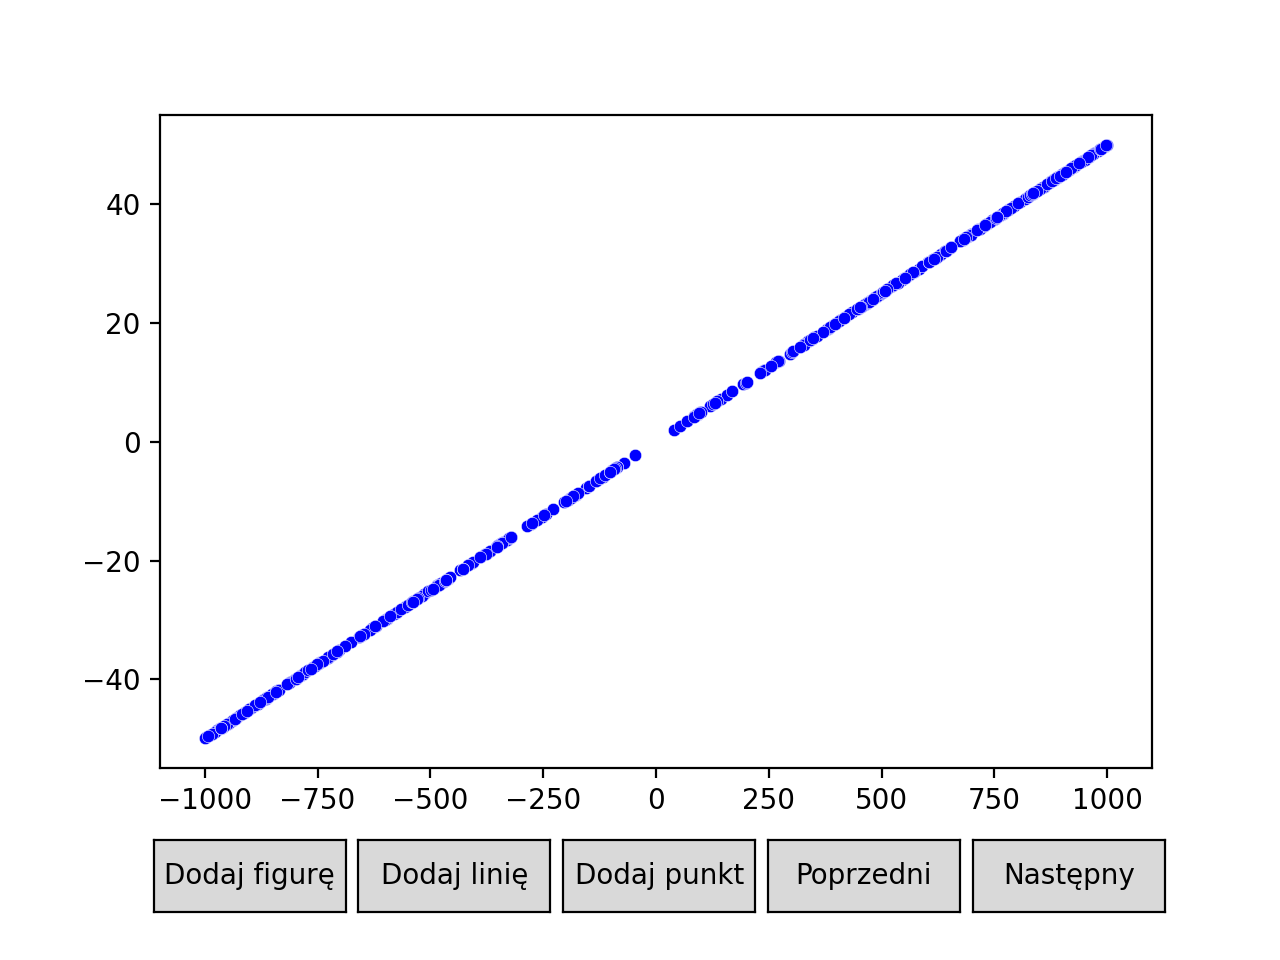

In [237]:
scenes=[]
for i in range(4):
    scenes.append(Scene([PointsCollection(all_points[3][i], color='blue',s=20,edgecolors="white",linewidths=0.2)]))
plot7 = Plot(scenes = scenes)
plot7.draw()

<IPython.core.display.Javascript object>


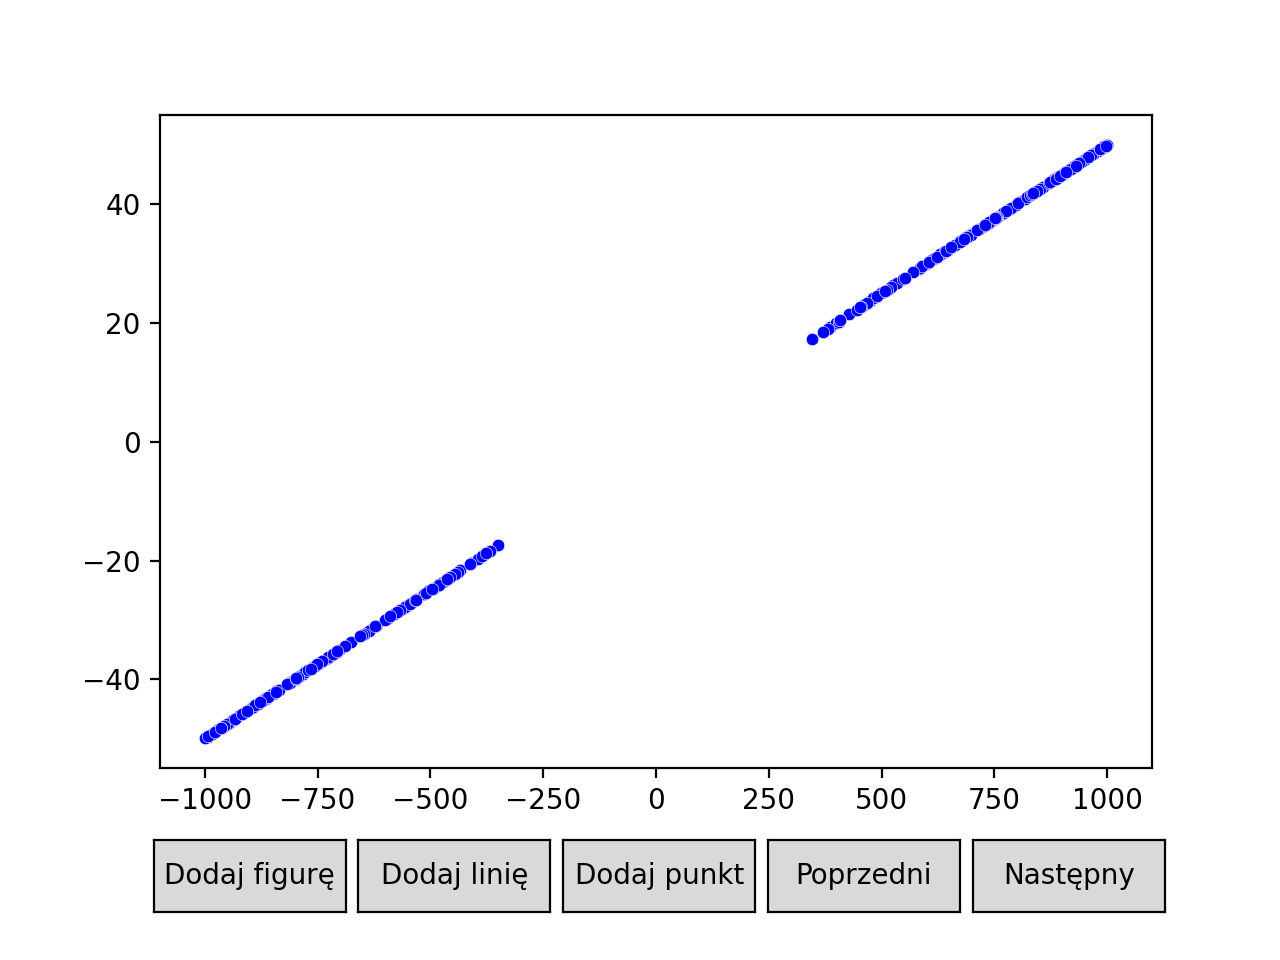

In [240]:
scenes=[]
for i in range(4):
    scenes.append(Scene([PointsCollection(all_points[7][i], color='blue',s=20,edgecolors="white",linewidths=0.2)]))
plot7 = Plot(scenes = scenes)
plot7.draw()

<IPython.core.display.Javascript object>


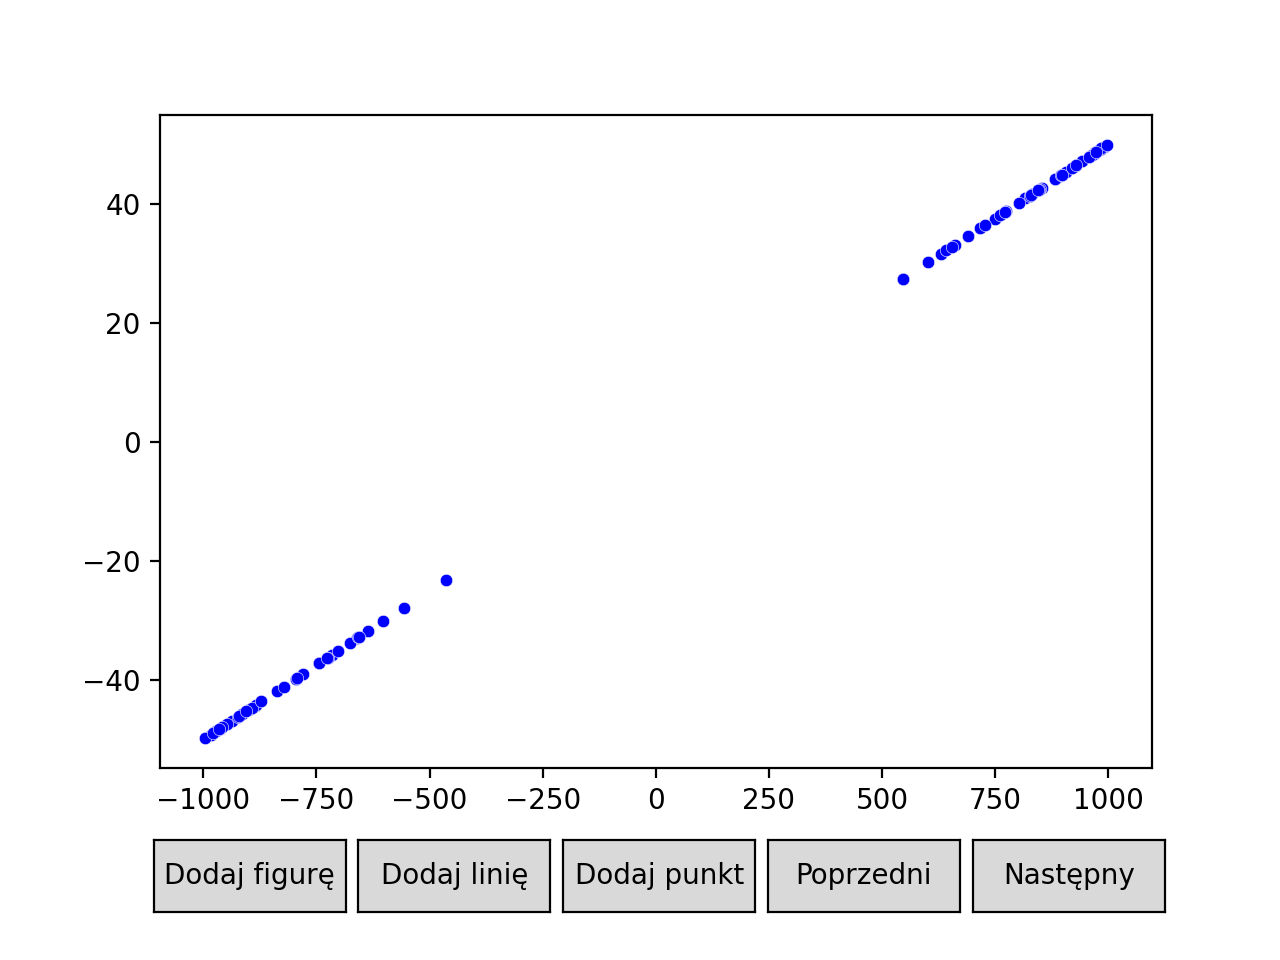

In [245]:
scenes=[]
for i in range(4):
    scenes.append(Scene([PointsCollection(all_points[10][i], color='blue',s=20,edgecolors="white",linewidths=0.2)]))
plot7 = Plot(scenes = scenes)
plot7.draw()

<IPython.core.display.Javascript object>


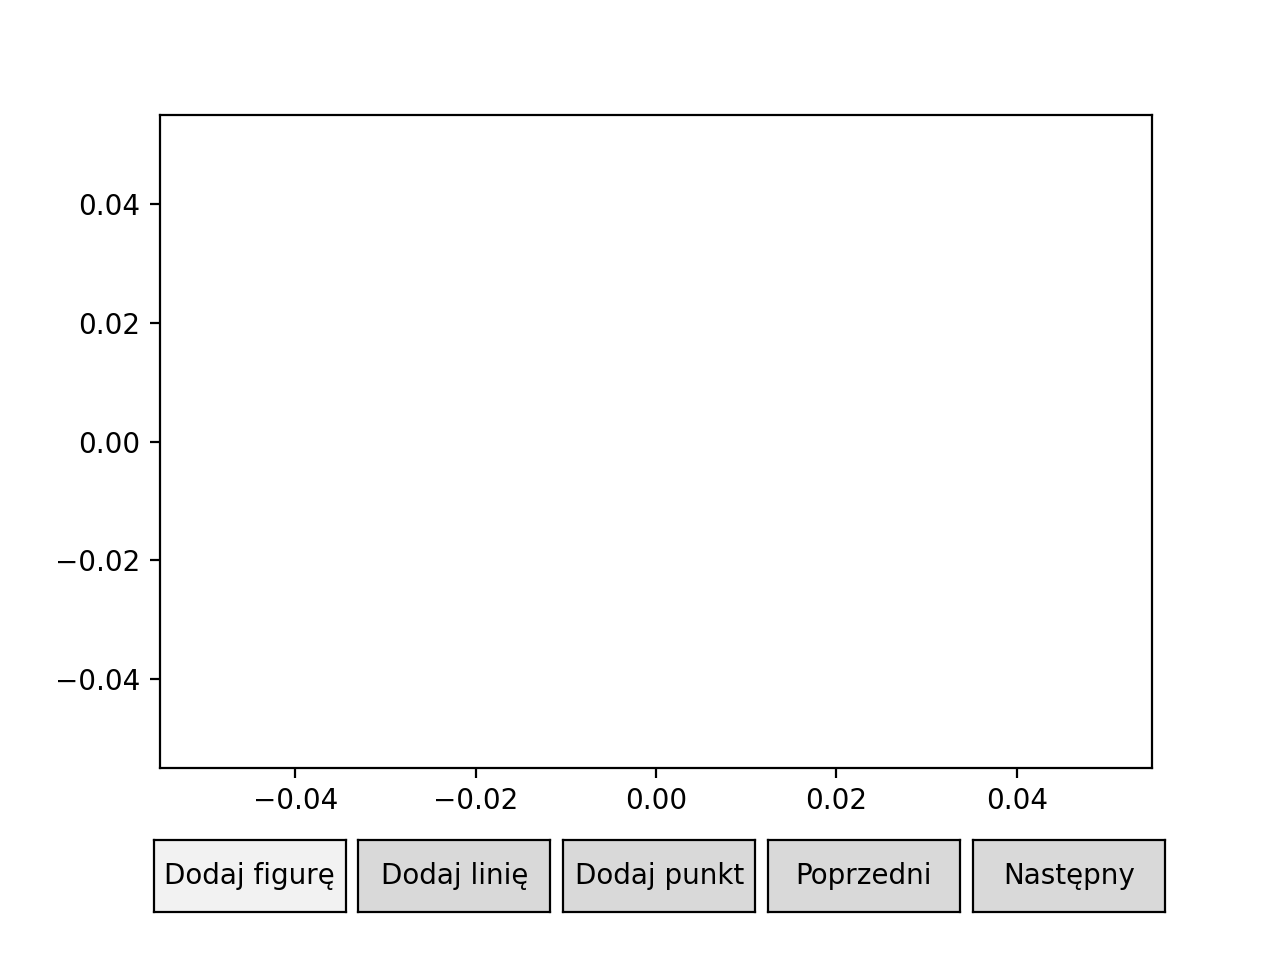

(7156975058715.969, -40411588513231.85)


In [268]:
scenes=[]
for i in range(4):
    scenes.append(Scene([PointsCollection(all_points[8][i], color='blue',s=20,edgecolors="white",linewidths=0.2)]))
plot7 = Plot(scenes = scenes)
plot7.draw()

## Precyzja float32

In [417]:
tab2_f32 = np.float32(tab2)
tab4_f32 = np.float32(tab4)
tab_f32 = [tab2_f32,tab4_f32]

#### Zbiór b) wygenerowany

/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_4750/3508443624.py:123: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


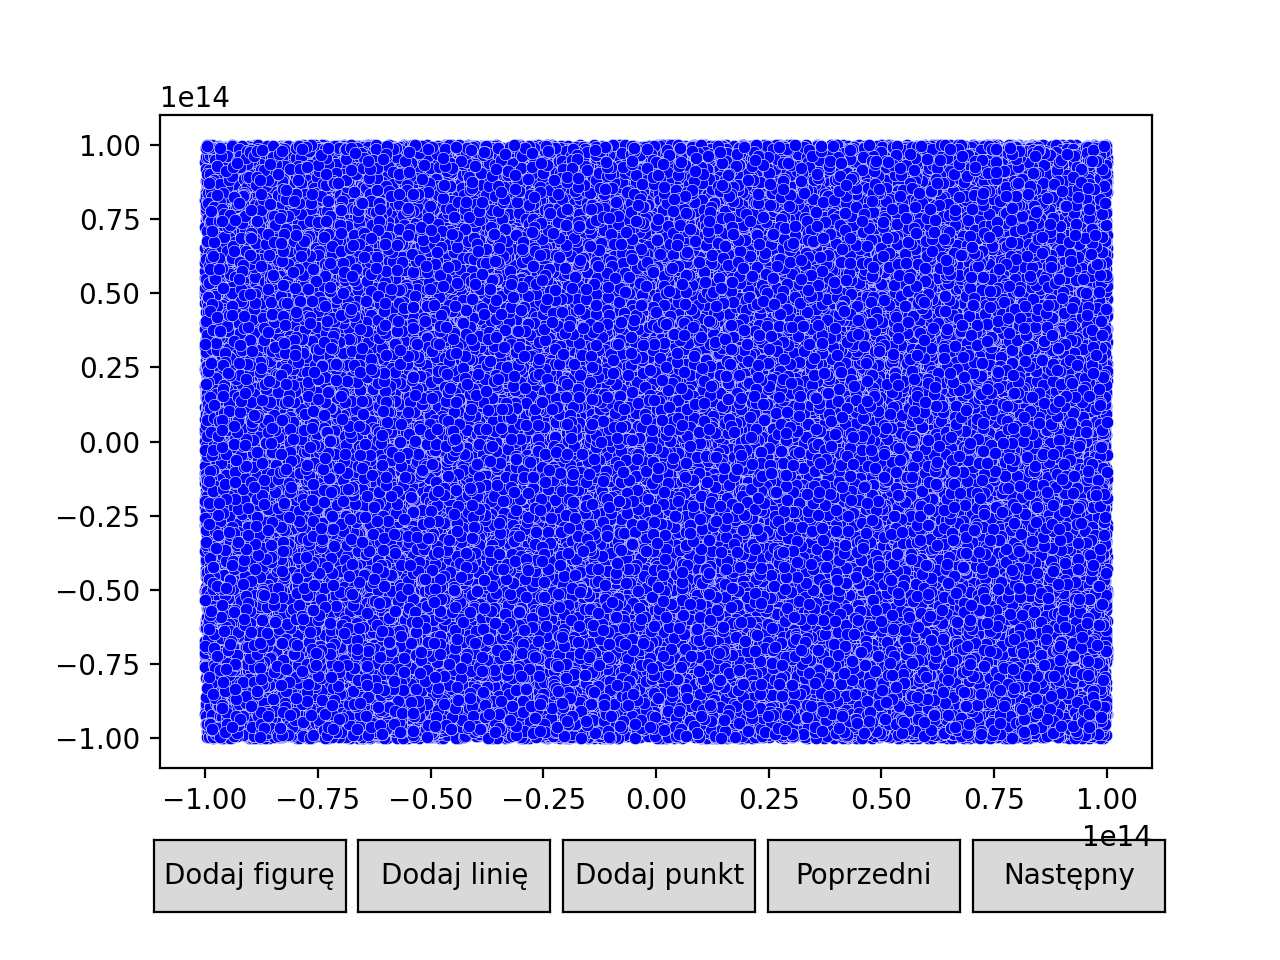

In [418]:
points = PointsCollection(tab2_f32,c="blue",s=20,edgecolors="white",linewidths=0.2)
scenes=[Scene([points])]
plot_32 = Plot(scenes = scenes,rect = "scatter")
plot_32.draw()

#### Zbiór d) wygenerowany

/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_4750/3508443624.py:123: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


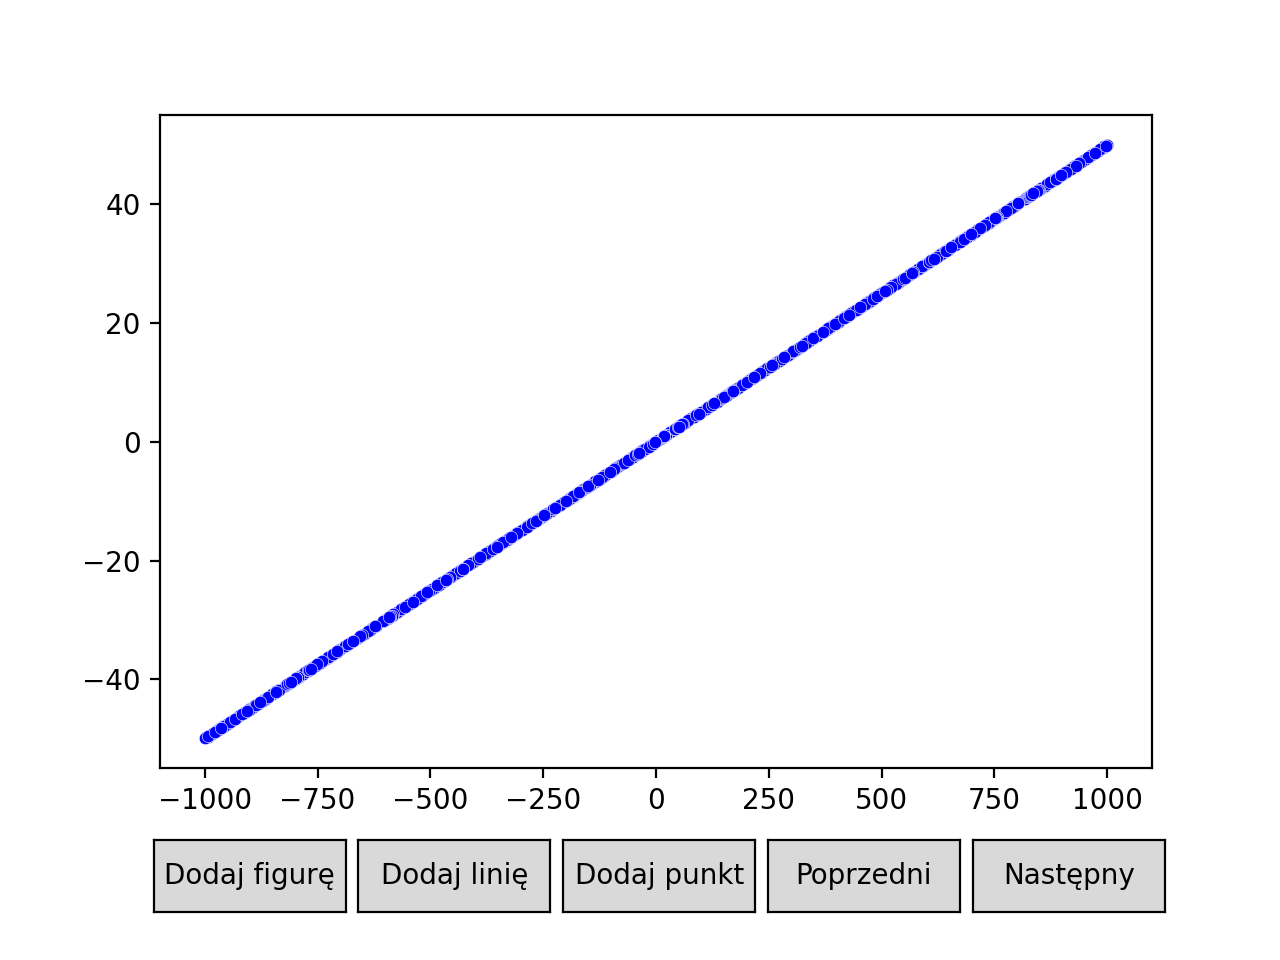

In [290]:
points = PointsCollection(tab4_f32,c="blue",s=20,edgecolors="white",linewidths=0.2)
scenes=[Scene([points])]
plot_32 = Plot(scenes = scenes,rect = "scatter")
plot_32.draw()

#### Generowanie wartości oraz tablic przechowujacych wartości punktów dla poszczególnych precyzji i matrixów

In [375]:
tab_old = tab_new
tab_new = [[],[]]
for i in range(len(tab_f32)):
    for j in range(len(tab_f32[i])):
        t = [tab_f32[i][j]]
        for z in range(4):
            t.append([[],[],[],[]])
        tab_new[i].append(t)
between,nn = 10**-16,1
generate2x2(tab_f32,True,False,nn)
generate3x3(tab_f32,True,False,nn)
generatenp2x2(tab_f32,True,False,nn)
generatenp3x3(tab_f32,True,False,nn)
between,nn = 10**-14,2
generate2x2(tab_f32,True,False,nn)
generate3x3(tab_f32,True,False,nn)
generatenp2x2(tab_f32,True,False,nn)
generatenp3x3(tab_f32,True,False,nn)
between,nn = 10**-12,3
generate2x2(tab_f32,True,False,nn)
generate3x3(tab_f32,True,False,nn)
generatenp2x2(tab_f32,True,False,nn)
generatenp3x3(tab_f32,True,False,nn)
between,nn = 10**-10,4
generate2x2(tab_f32,True,False,nn)
generate3x3(tab_f32,True,False,nn)
generatenp2x2(tab_f32,True,False,nn)
generatenp3x3(tab_f32,True,False,nn)

In [378]:
print("Kolejne wartosci to matrix 2x2, matrix 3x3, matrix numpy 3x3 , matrix numpy 2x2")
print("                 Punkt                10^-16       10^-14    10^-12    10^-10")
for i in range(5):
    tb_ = tab_new[0][i]
    string ="(" +str(tb_[0][0]) +"," + str(tb_[0][1]) +")" + ","
    for j in range(1,len(tb_)):
        string += "(" + str(tb_[j][0][0])  +"," + str(tb_[j][1][0]) +"," + str(tb_[j][2][0]) +"," + str(tb_[j][3][0])+ ")"
    print(string)
print("            Punkt         10^-16       10^-14    10^-12       10^-10")
for i in range(5):
    tb_ = tab_new[1][i]
    string = "(" +str(tb_[0][0]) +"," + str(tb_[0][1]) +")"  + ","
    for j in range(1,len(tb_)):
        string += " (" + str(tb_[j][0][0])  +"," + str(tb_[j][1][0]) +"," + str(tb_[j][2][0]) +"," + str(tb_[j][3][0])+ ")"
    print(string)

Kolejne wartosci to matrix 2x2, matrix 3x3, matrix numpy 3x3 , matrix numpy 2x2
                 Punkt                10^-16       10^-14    10^-12    10^-10
(7156975300000.0,-40411590000000.0),(-1,-1,-1,-1)(-1,-1,-1,-1)(-1,-1,-1,-1)(-1,-1,-1,-1)
(-13219234000000.0,43387386000000.0),(1,1,1,1)(1,1,1,1)(1,1,1,1)(1,1,1,1)
(-99240340000000.0,-27685850000000.0),(-1,-1,-1,-1)(-1,-1,-1,-1)(-1,-1,-1,-1)(-1,-1,-1,-1)
(-18270489000000.0,34471374000000.0),(1,1,1,1)(1,1,1,1)(1,1,1,1)(1,1,1,1)
(-77386530000000.0,-95277240000000.0),(-1,-1,-1,-1)(-1,-1,-1,-1)(-1,-1,-1,-1)(-1,-1,-1,-1)
            Punkt         10^-16       10^-14    10^-12       10^-10
(491.28284,24.614143), (1,1,1,1) (1,1,1,1) (1,1,1,1) (1,1,1,1)
(144.39153,7.269576), (-1,-1,-1,-1) (-1,-1,-1,-1) (-1,-1,-1,-1) (-1,-1,-1,-1)
(346.07672,17.353836), (-1,0,-1,-1) (-1,0,0,-1) (0,0,0,0) (0,0,0,0)
(583.4237,29.221186), (1,1,1,1) (1,1,1,1) (1,1,1,1) (1,1,1,1)
(39.101635,2.005082), (1,1,1,1) (1,1,1,1) (1,1,1,1) (1,1,1,1)


In [379]:
sets2 = [[],[]]
for i in range(2):
    for j in range(4):
            sets2[i].append([[0,0,0],[0,0,0],[0,0,0],[0,0,0]])
for i in range(2):
    for j in range(len(tab_new[i])):
        for k in range(1,5):
            for f in range(4):
                number_ = tab_new[i][j][k][f][0]
                sets2[i][k-1][f][number_+1]+=1
for i in range(2):
    for j in range(4):
        for k in range(4):
            sets2[i][j][k] = list(reversed(sets2[i][j][k])) 


In [380]:
print("         Matrix 2x2           Matrix 3x3         Numpy 3x3          Numpy 2x2 ")
print("      Lewo Środek Prawo")
for i in range(2):
    print("Set:" + str(i))
    print("d^-16",sets2[i][0])
    print("d^-14",sets2[i][1])
    print("d^-12",sets2[i][2])
    print("d^-10",sets2[i][3])

         Matrix 2x2           Matrix 3x3         Numpy 3x3          Numpy 2x2 
      Lewo Środek Prawo
Set:0
d^-16 [[50058, 7, 49935], [50061, 0, 49939], [50061, 0, 49939], [50062, 0, 49938]]
d^-14 [[50058, 7, 49935], [50061, 0, 49939], [50061, 0, 49939], [50062, 0, 49938]]
d^-12 [[50058, 7, 49935], [50061, 0, 49939], [50061, 0, 49939], [50062, 0, 49938]]
d^-10 [[50058, 7, 49935], [50061, 0, 49939], [50061, 0, 49939], [50062, 0, 49938]]
Set:1
d^-16 [[408, 165, 427], [447, 56, 497], [480, 3, 517], [489, 0, 511]]
d^-14 [[408, 166, 426], [392, 189, 419], [401, 170, 429], [482, 15, 503]]
d^-12 [[392, 189, 419], [392, 189, 419], [392, 189, 419], [419, 123, 458]]
d^-10 [[392, 189, 419], [392, 189, 419], [392, 189, 419], [392, 189, 419]]


In [404]:
all_points2 = []
for i in range(16):
    all_points2.append([[],[]])
for k1 in range(4):
    for k2 in range(4):
        for i in range(2):
            for j in range(len(tab_new[i])):
                temp = tab_new[i][j]
                if temp[1][k1] != temp[2][k2]:
                    all_points2[k1*4+k2][i].append((temp[0][0],temp[0][1]))
all_points3 = []
for i in range(16):
    all_points3.append([[],[]])
for k1 in range(4):
    for k2 in range(4):
        for i in range(2):
            for j in range(len(tab_new[i])):
                temp = tab_new[i][j]
                if temp[1][k1] != temp[3][k2]:
                    all_points3[k1*4+k2][i].append((temp[0][0],temp[0][1]))

### Wykresy b) i d) oraz pokazane roznice miedzy precyzjami

<IPython.core.display.Javascript object>


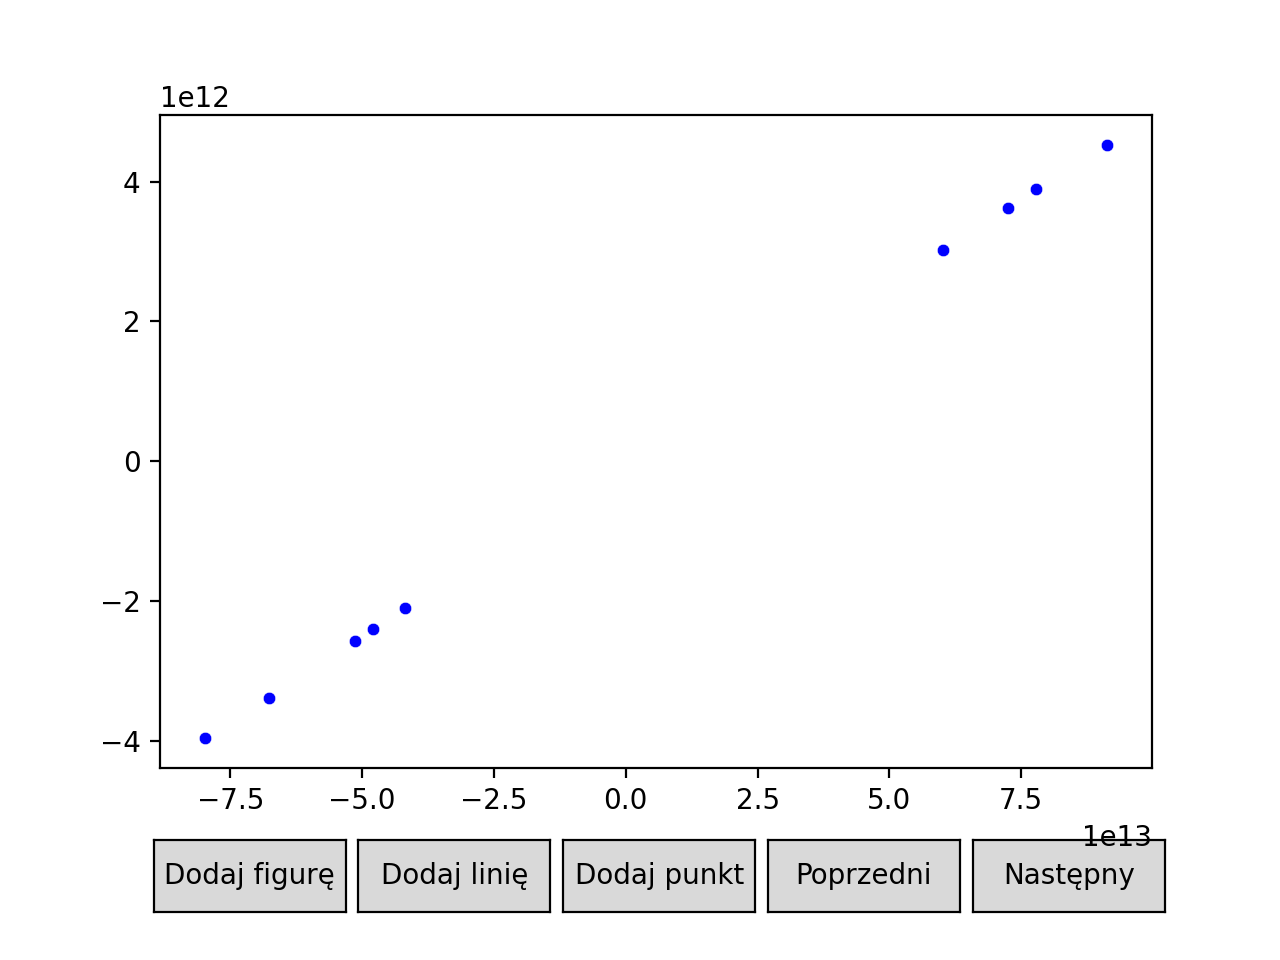

In [399]:
scenes=[]
for i in range(2):
    scenes.append(Scene([PointsCollection(all_points2[1][i], color='blue',s=20,edgecolors="white",linewidths=0.2)]))
plot7 = Plot(scenes = scenes)
plot7.draw()

/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_4750/3508443624.py:123: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


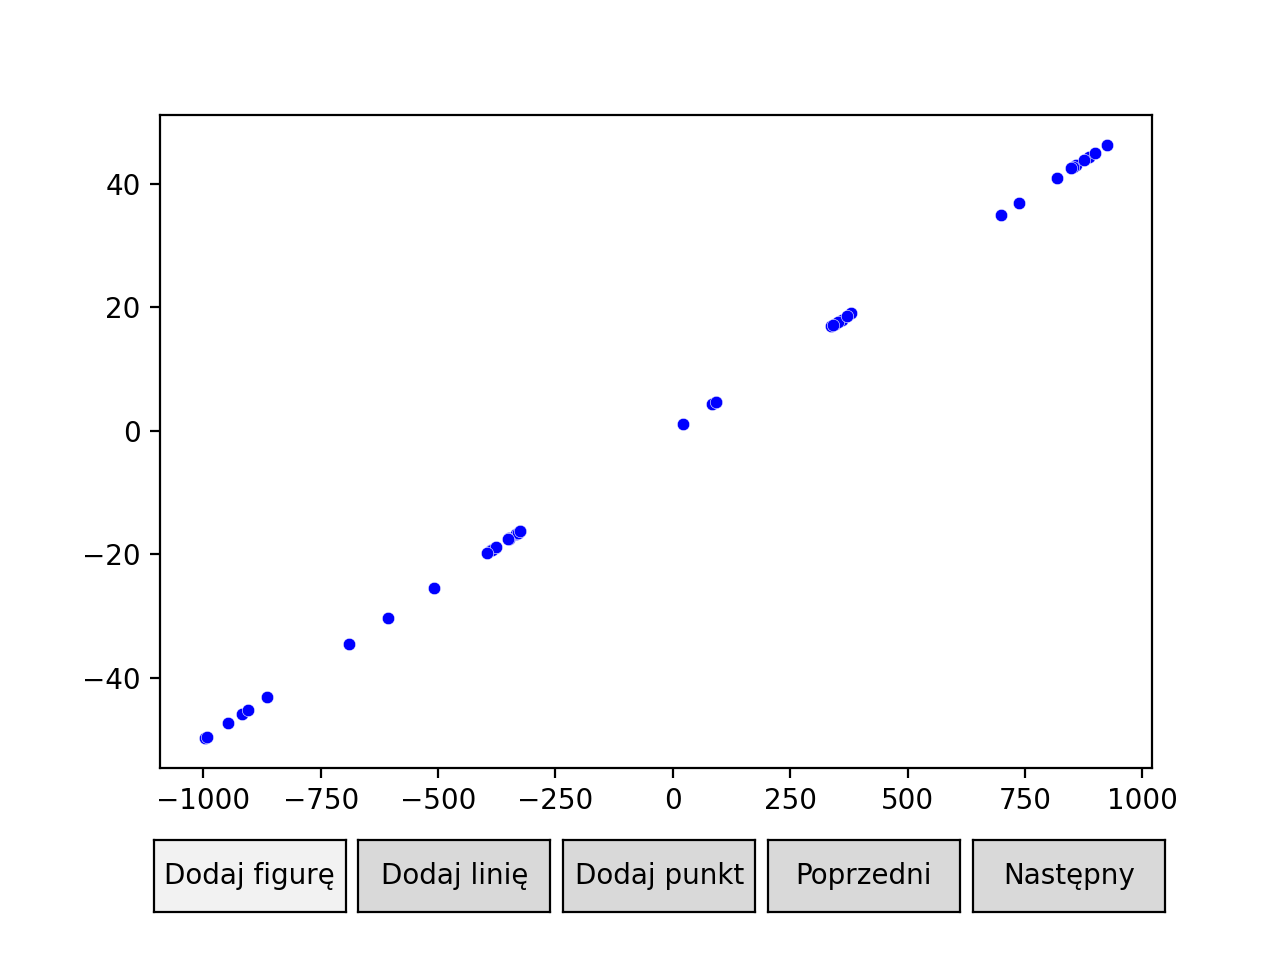

In [408]:
scenes=[]
for i in range(2):
    scenes.append(Scene([PointsCollection(all_points2[2][i], color='blue',s=20,edgecolors="white",linewidths=0.2)]))
plot7 = Plot(scenes = scenes)
plot7.draw()

/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_4750/3508443624.py:123: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


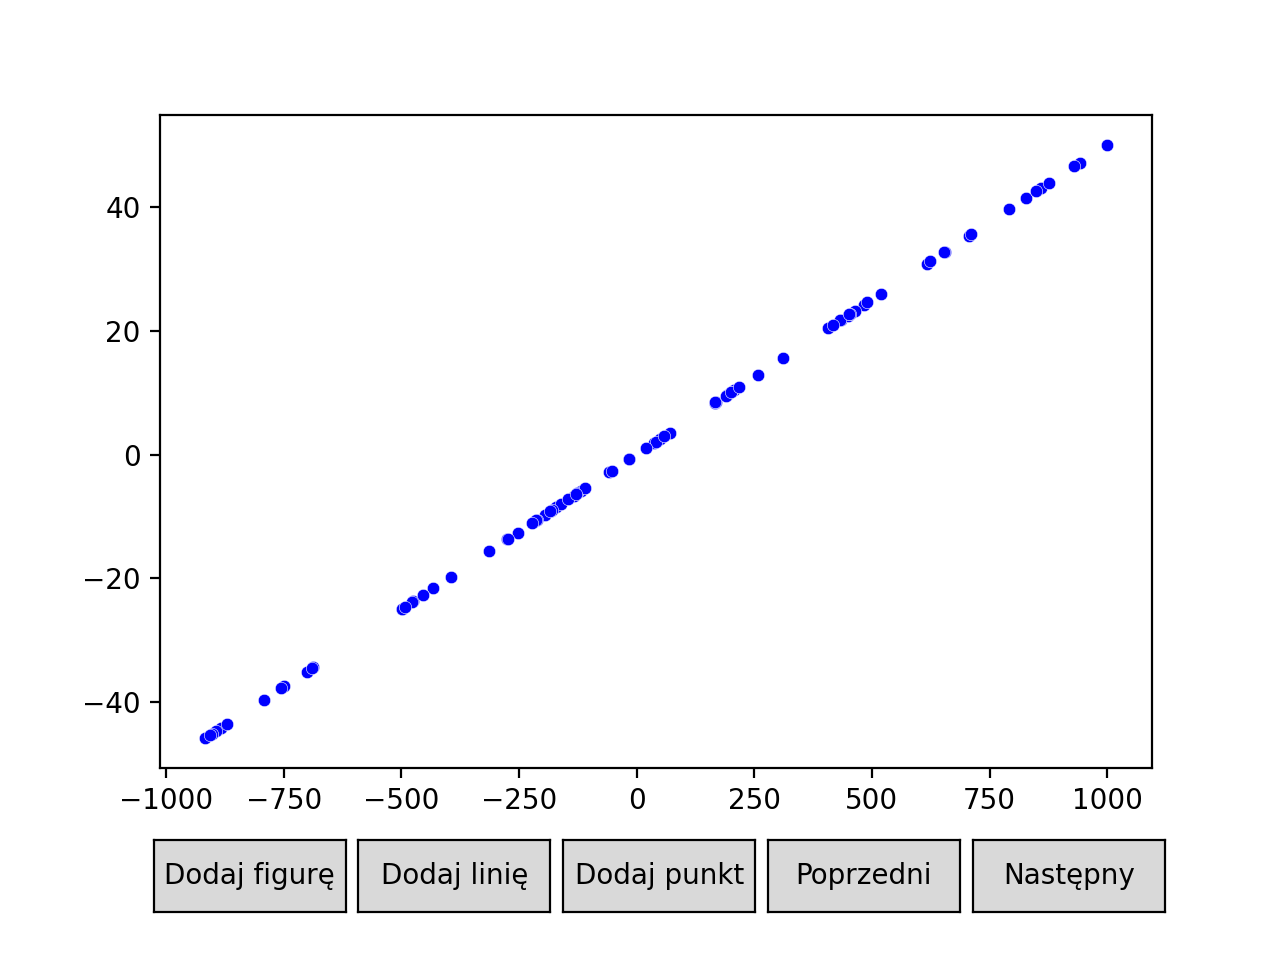

In [409]:
scenes=[]
for i in range(2):
    scenes.append(Scene([PointsCollection(all_points3[7][i], color='blue',s=20,edgecolors="white",linewidths=0.2)]))
plot7 = Plot(scenes = scenes)
plot7.draw()


/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_4750/3508443624.py:123: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


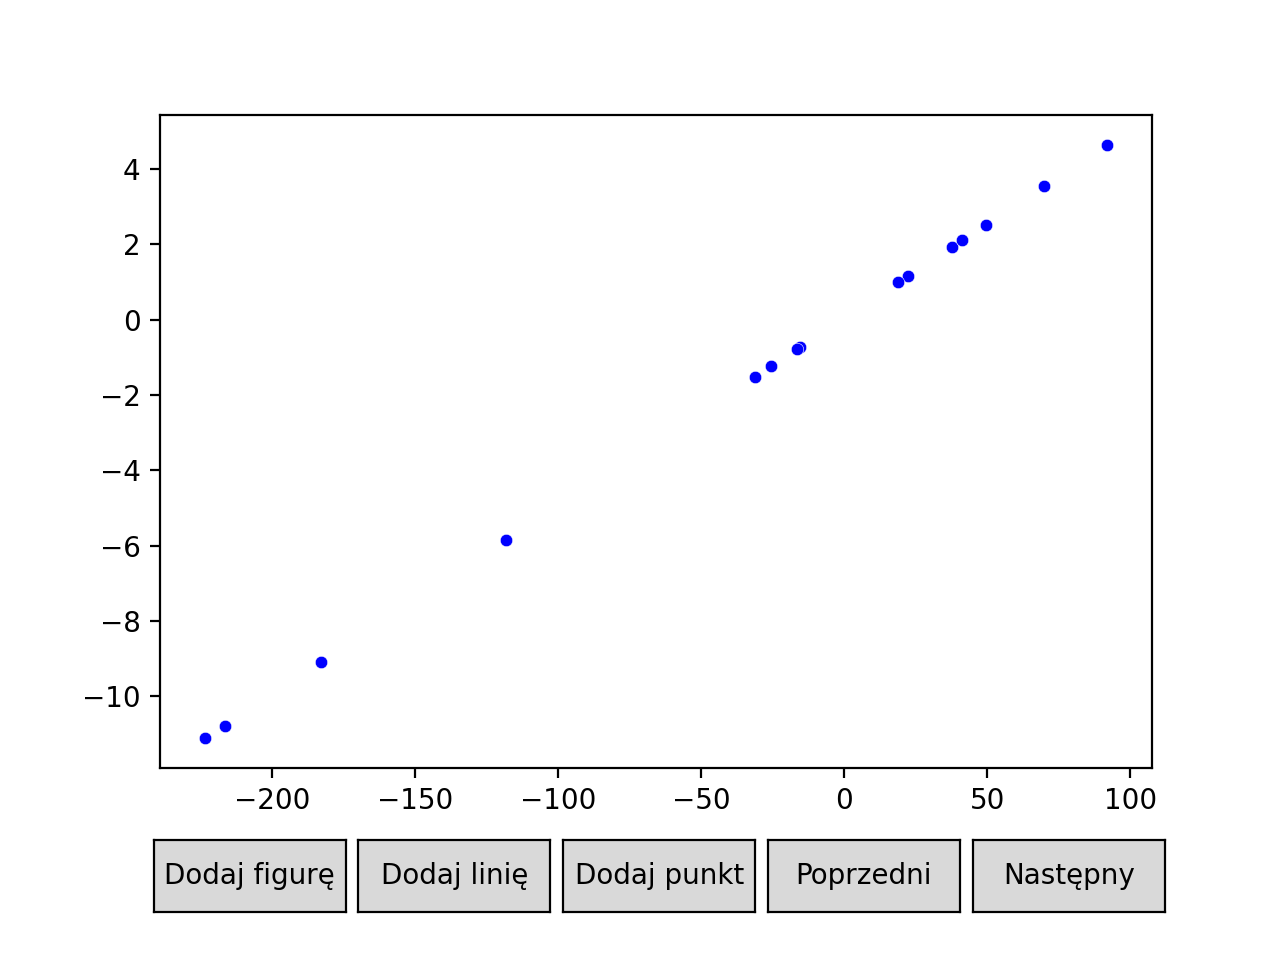

In [411]:
scenes=[]
for i in range(2):
    scenes.append(Scene([PointsCollection(all_points2[15][i], color='blue',s=20,edgecolors="white",linewidths=0.2)]))
plot7 = Plot(scenes = scenes)
plot7.draw()

<IPython.core.display.Javascript object>


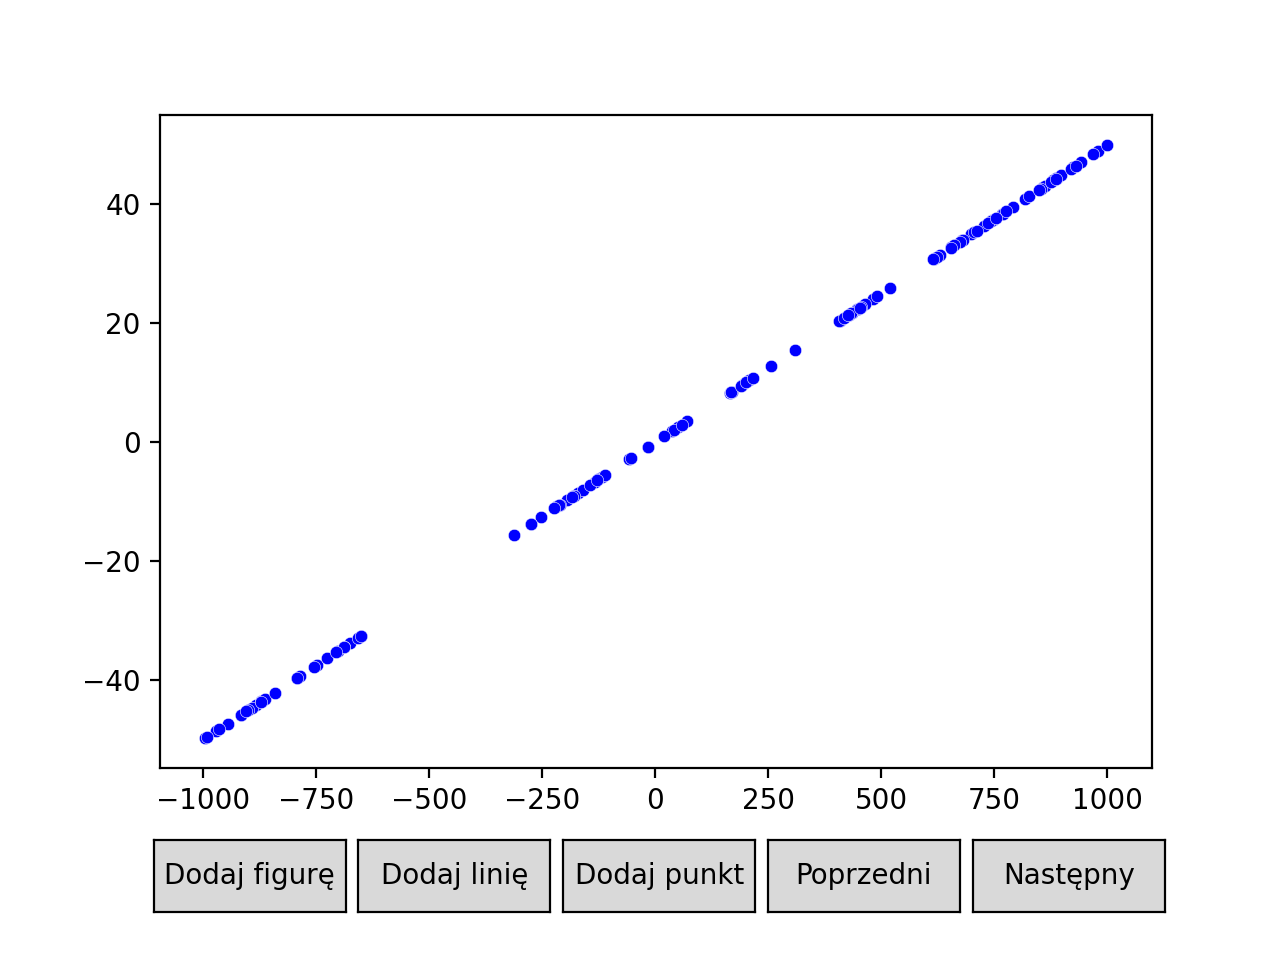

In [413]:
scenes=[]
for i in range(2):
    scenes.append(Scene([PointsCollection(all_points3[6][i], color='blue',s=20,edgecolors="white",linewidths=0.2)]))
plot7 = Plot(scenes = scenes)
plot7.draw()

#### Wszystkie wykresy zbiorów d) na scenach miedzy precyzjami 10^-16 oraz 10^-14

/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_4750/3508443624.py:123: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


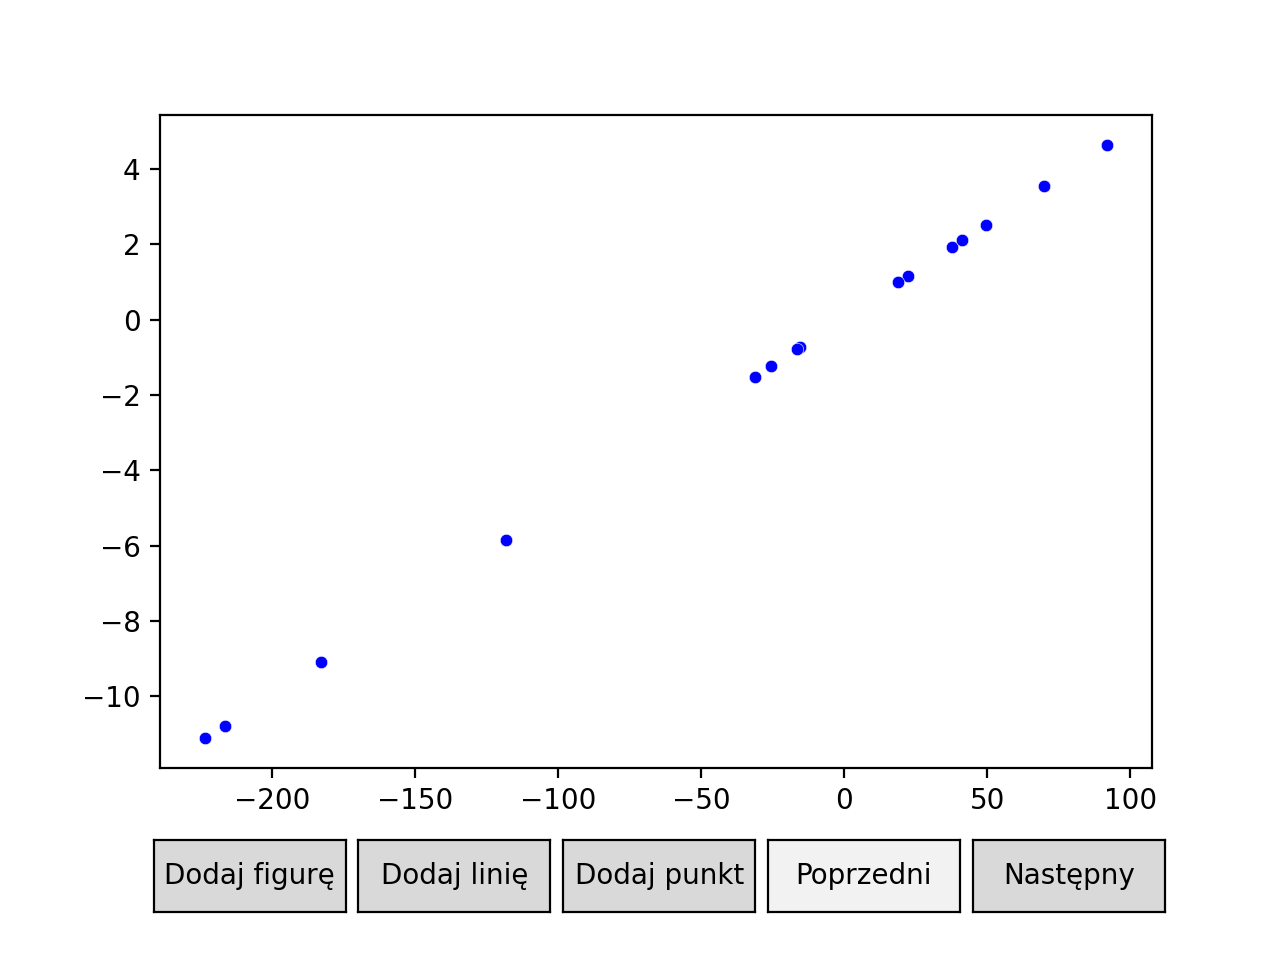

In [416]:
scenes=[]
for i in range(16):
    scenes.append(Scene([PointsCollection(all_points2[i][1], color='blue',s=20,edgecolors="white",linewidths=0.2)]))
plot7 = Plot(scenes = scenes)
plot7.draw()

#### Wszystkie wykresy zbiorów d) na scenach miedzy precyzjami 10^-16 oraz 10^-12

/var/folders/j8/ycql35hs3415ybxz7vjtcrr40000gn/T/ipykernel_4750/3508443624.py:123: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


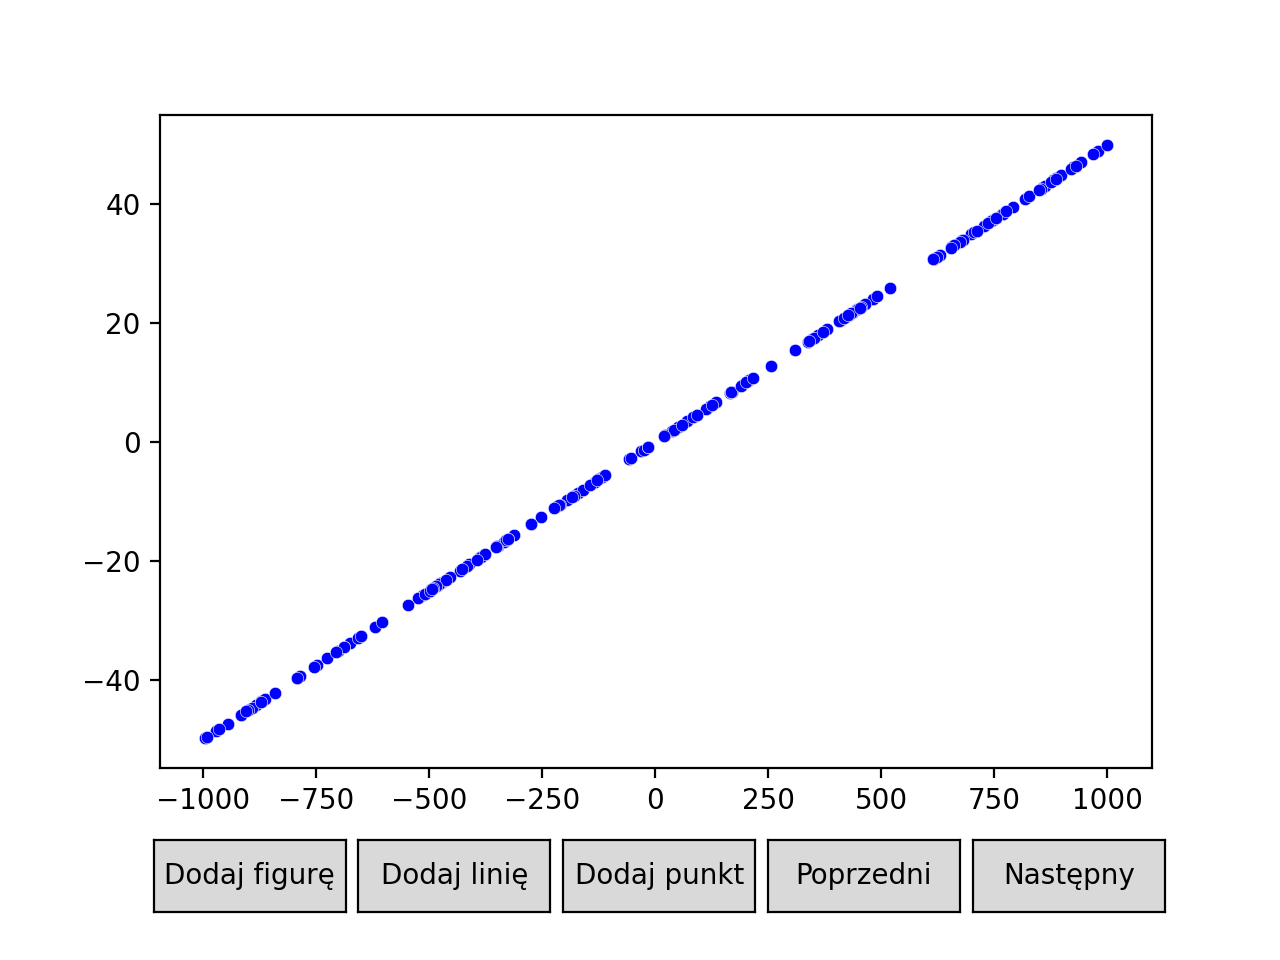

In [415]:
scenes=[]
for i in range(16):
    scenes.append(Scene([PointsCollection(all_points3[i][1], color='blue',s=20,edgecolors="white",linewidths=0.2)]))
plot7 = Plot(scenes = scenes)
plot7.draw()

### Poszczególne czasy algorytmów do wyznaczania wyznaczników dla wszystkich zbiorów

In [443]:
left,right,linear = [[],[],[],[]],[[],[],[],[]],[[],[],[],[]]
timeit.timeit(lambda:generate2x2(tab,False,True),number=5)


0.5114981250371784

In [444]:
left,right,linear = [[],[],[],[]],[[],[],[],[]],[[],[],[],[]]
timeit.timeit(lambda:generate3x3(tab,False,True),number=5)

0.6142389590386301

In [445]:
left,right,linear = [[],[],[],[]],[[],[],[],[]],[[],[],[],[]]
timeit.timeit(lambda:generatenp2x2(tab,False,True),number=5)

2.848187334020622

In [446]:
left,right,linear = [[],[],[],[]],[[],[],[],[]],[[],[],[],[]]
timeit.timeit(lambda:generatenp3x3(tab,False,True),number=5)

3.052350457990542